In [2]:
# ===== [1] 설치 및 기본 설정 =====
!pip install segmentation-models-pytorch -q
!pip install albumentations -q

import os
import numpy as np
import cv2
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
print(f"✅ GPU: {torch.cuda.get_device_name(0)}")

# GPU 메모리 확인
if torch.cuda.is_available():
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU Memory: {gpu_mem:.1f} GB")

def print_gpu_memory():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        total = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"🔧 GPU: {allocated:.1f}GB / {total:.1f}GB ({allocated/total*100:.1f}%)")

✅ Using device: cuda
✅ GPU: NVIDIA A100-SXM4-40GB
✅ GPU Memory: 42.5 GB


In [3]:
# ===== [2] Google Drive 마운트 & 압축 해제 =====
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive'
dataset_path = '/content/dataset'
os.makedirs(dataset_path, exist_ok=True)

print("📦 Train 압축 해제 중...")
!unzip -q "{drive_path}/train_dataset.zip" -d "{dataset_path}/train"
print("✅ Train 완료!")

print("📦 Val 압축 해제 중...")
!unzip -q "{drive_path}/val_dataset.zip" -d "{dataset_path}/val"
print("✅ Val 완료!")

Mounted at /content/drive
📦 Train 압축 해제 중...
✅ Train 완료!
📦 Val 압축 해제 중...
✅ Val 완료!


In [4]:
# ===== [3] Semantic Mask 생성 =====
CLASS_MAP = {'Background': 0, 'Pollution': 1, 'Damaged': 2, 'Outline': 3}

def create_semantic_mask(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    width, height = data['image_info']['width'], data['image_info']['height']
    mask = np.zeros((height, width), dtype=np.uint8)

    outline = data.get('swelling', {}).get('battery_outline', [])
    if outline:
        points = np.array(outline, dtype=np.float32).reshape(-1, 2).astype(np.int32)
        cv2.fillPoly(mask, [points], color=3)

    defects = data.get('defects')
    if defects:
        for defect in defects:
            name, points = defect.get('name'), defect.get('points', [])
            if name in CLASS_MAP and points:
                pts = np.array(points, dtype=np.float32).reshape(-1, 2).astype(np.int32)
                cv2.fillPoly(mask, [pts], color=CLASS_MAP[name])
    return mask

def generate_masks(label_path, mask_path):
    os.makedirs(mask_path, exist_ok=True)
    for f in tqdm(os.listdir(label_path)):
        if f.endswith('.json'):
            mask = create_semantic_mask(os.path.join(label_path, f))
            cv2.imwrite(os.path.join(mask_path, f.replace('.json', '_mask.png')), mask)

train_base = '/content/dataset/train/content/split_dataset/train'
val_base = '/content/dataset/val/content/split_dataset/val'

print("📦 Train Mask 생성...")
generate_masks(f'{train_base}/labels', f'{train_base}/semantic_masks')
print("📦 Val Mask 생성...")
generate_masks(f'{val_base}/labels', f'{val_base}/semantic_masks')
print("✅ Mask 생성 완료!")

📦 Train Mask 생성...


100%|██████████| 17797/17797 [02:15<00:00, 131.22it/s]


📦 Val Mask 생성...


100%|██████████| 4450/4450 [00:33<00:00, 131.83it/s]

✅ Mask 생성 완료!


In [5]:
# ===== [4] Dataset & DataLoader (Damaged 최적화) =====

# 🔥 Damaged 성능 최우선 설정
IMG_SIZE = 512
BATCH_SIZE = 16        # 작은 배치 → Damaged 학습에 유리
NUM_WORKERS = 4

print(f"🔥 Damaged 최적화 설정: IMG={IMG_SIZE}, BATCH={BATCH_SIZE}, WORKERS={NUM_WORKERS}")

class BatteryDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, img_size=512):
        self.image_dir, self.mask_dir = image_dir, mask_dir
        self.transform, self.img_size = transform, img_size
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.png')]
        self.images = [f for f in self.images if os.path.exists(os.path.join(mask_dir, f.replace('.png', '_mask.png')))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = cv2.cvtColor(cv2.imread(os.path.join(self.image_dir, self.images[idx])), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.mask_dir, self.images[idx].replace('.png', '_mask.png')), 0)
        img = cv2.resize(img, (self.img_size, self.img_size))
        mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']
        return img, mask.long()

# 🔥 강화된 Augmentation (Damaged 검출 특화)
train_transform = A.Compose([
    # 기본 뒤집기
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),

    # 기하학적 변환 강화
    A.Affine(scale=(0.7, 1.3), rotate=(-45, 45), shear=(-15, 15), p=0.6),

    # 🔥 랜덤 크롭 (작은 결함 확대 효과)
    A.OneOf([
        A.RandomCrop(height=384, width=384, p=1.0),
        A.RandomCrop(height=448, width=448, p=1.0),
        A.CenterCrop(height=448, width=448, p=1.0),
    ], p=0.4),
    A.Resize(IMG_SIZE, IMG_SIZE),

    # 탄성 변형 (결함 모양 다양화)
    A.OneOf([
        A.ElasticTransform(alpha=150, sigma=8, p=0.5),
        A.GridDistortion(num_steps=7, distort_limit=0.4, p=0.5),
        A.OpticalDistortion(distort_limit=0.3, shift_limit=0.2, p=0.5),
    ], p=0.4),

    # 🔥 색상 변화 강화 (결함 색상 다양화)
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15, p=0.7),
    A.OneOf([
        A.CLAHE(clip_limit=4.0, p=0.5),
        A.Sharpen(alpha=(0.2, 0.5), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    ], p=0.4),

    # 노이즈 추가 (일반화 능력 향상)
    A.OneOf([
        A.GaussNoise(var_limit=(10, 50), p=0.5),
        A.ISONoise(p=0.5),
    ], p=0.2),

    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# DataLoader
train_dataset = BatteryDataset(f'{train_base}/images', f'{train_base}/semantic_masks', train_transform, img_size=IMG_SIZE)
val_dataset = BatteryDataset(f'{val_base}/images', f'{val_base}/semantic_masks', val_transform, img_size=IMG_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"✅ Train: {len(train_dataset)}장, {len(train_loader)} batches")
print(f"✅ Val: {len(val_dataset)}장, {len(val_loader)} batches")

🔥 Damaged 최적화 설정: IMG=512, BATCH=16, WORKERS=4
✅ Train: 17797장, 1113 batches
✅ Val: 4450장, 279 batches


/tmp/ipython-input-867448642.py:52: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=0.3, shift_limit=0.2, p=0.5),
/tmp/ipython-input-867448642.py:65: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.5),


In [6]:
# ===== [5] 모델 (EfficientNet-B5 + DeepLabV3+) =====

model = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b5",
    encoder_weights="imagenet",
    in_channels=3,
    classes=4
)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"✅ EfficientNet-B5 + DeepLabV3+ 모델 생성!")
print(f"✅ Total Parameters: {total_params/1e6:.1f}M")
print_gpu_memory()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

✅ EfficientNet-B5 + DeepLabV3+ 모델 생성!
✅ Total Parameters: 29.5M
🔧 GPU: 0.1GB / 42.5GB (0.3%)


In [7]:
# ===== [6] 🔥 Focal + Dice + Boundary Loss =====

class FocalDiceBoundaryLoss(nn.Module):
    def __init__(self, num_classes=4, class_weights=None, gamma=2.0,
                 focal_weight=0.4, dice_weight=0.4, boundary_weight=0.2):
        super().__init__()
        self.num_classes = num_classes
        self.gamma = gamma
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight
        self.boundary_weight = boundary_weight
        self.ce = nn.CrossEntropyLoss(weight=class_weights, reduction='none')

    def focal_loss(self, pred, target):
        ce_loss = self.ce(pred, target)
        pt = torch.exp(-ce_loss)
        focal = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal

    def dice_loss(self, pred, target):
        pred = F.softmax(pred, dim=1)
        target_onehot = F.one_hot(target, self.num_classes).permute(0, 3, 1, 2).float()

        intersection = (pred * target_onehot).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target_onehot.sum(dim=(2, 3))
        dice = (2 * intersection + 1e-6) / (union + 1e-6)

        # 🔥 Damaged(2) 클래스 Dice에 추가 가중치
        weights = torch.tensor([1.0, 1.5, 3.0, 1.0]).to(pred.device)
        weighted_dice = (dice * weights).sum() / weights.sum()

        return 1 - weighted_dice

    def boundary_loss(self, pred, target):
        pred_softmax = F.softmax(pred, dim=1)

        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(target.device)
        sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(target.device)

        target_float = target.float().unsqueeze(1)
        edge_x = F.conv2d(target_float, sobel_x, padding=1)
        edge_y = F.conv2d(target_float, sobel_y, padding=1)
        boundary = (edge_x.abs() + edge_y.abs()) > 0
        boundary = boundary.float().squeeze(1)

        ce_loss = self.ce(pred, target)
        boundary_ce = (ce_loss * boundary).sum() / (boundary.sum() + 1e-6)

        return boundary_ce

    def forward(self, pred, target):
        focal = self.focal_loss(pred, target)
        dice = self.dice_loss(pred, target)
        boundary = self.boundary_loss(pred, target)

        return self.focal_weight * focal + self.dice_weight * dice + self.boundary_weight * boundary

# 🔥 클래스 가중치 (Damaged 20배!)
class_weights = torch.tensor([0.1, 3.0, 20.0, 1.0]).to(device)
criterion = FocalDiceBoundaryLoss(
    num_classes=4,
    class_weights=class_weights,
    gamma=2.0,
    focal_weight=0.4,
    dice_weight=0.4,
    boundary_weight=0.2
)
print("✅ Focal + Dice + Boundary Loss 설정!")
print("✅ Class Weights: BG=0.1, Pollution=3.0, Damaged=20.0, Outline=1.0")

✅ Focal + Dice + Boundary Loss 설정!
✅ Class Weights: BG=0.1, Pollution=3.0, Damaged=20.0, Outline=1.0


In [8]:
# ===== [7] Optimizer & Scheduler =====

# Layer-wise Learning Rate
encoder_params = []
decoder_params = []

for name, param in model.named_parameters():
    if 'encoder' in name:
        encoder_params.append(param)
    else:
        decoder_params.append(param)

optimizer = torch.optim.AdamW([
    {'params': encoder_params, 'lr': 5e-5},
    {'params': decoder_params, 'lr': 2e-4}
], weight_decay=1e-4)

NUM_EPOCHS = 50
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[5e-4, 2e-3],
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy='cos'
)

scaler = torch.cuda.amp.GradScaler()

print("✅ AdamW + OneCycleLR 설정!")
print(f"✅ Encoder LR: 5e-5 → 5e-4, Decoder LR: 2e-4 → 2e-3")

✅ AdamW + OneCycleLR 설정!
✅ Encoder LR: 5e-5 → 5e-4, Decoder LR: 2e-4 → 2e-3


/tmp/ipython-input-1477228348.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [9]:
# ===== [8] 학습 함수 =====

def train_one_epoch(model, loader, criterion, optimizer, scheduler, scaler, device):
    model.train()
    total_loss = 0

    for images, masks in tqdm(loader, desc="Training"):
        try:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                output = model(images)
                loss = criterion(output, masks)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            total_loss += loss.item()

        except RuntimeError as e:
            if 'out of memory' in str(e):
                print('⚠️ OOM! Skipping batch...')
                torch.cuda.empty_cache()
                continue
            else:
                raise e

    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            with torch.cuda.amp.autocast():
                output = model(images)
                loss = criterion(output, masks)
            total_loss += loss.item()
    return total_loss / len(loader)

def calculate_miou(model, loader, device, num_classes=4):
    model.eval()
    iou_per_class = np.zeros(num_classes)
    count_per_class = np.zeros(num_classes)

    with torch.no_grad():
        for images, masks in loader:
            with torch.cuda.amp.autocast():
                preds = torch.argmax(model(images.to(device)), dim=1).cpu().numpy()
            masks = masks.numpy()

            for cls in range(num_classes):
                inter = np.sum((preds == cls) & (masks == cls))
                union = np.sum((preds == cls) | (masks == cls))
                if union > 0:
                    iou_per_class[cls] += inter / union
                    count_per_class[cls] += 1

    iou_per_class = np.divide(iou_per_class, count_per_class, where=count_per_class!=0)
    return np.mean(iou_per_class[count_per_class > 0]), iou_per_class

print("✅ 학습 함수 정의 완료!")

✅ 학습 함수 정의 완료!


In [10]:
# ===== [9] 학습 실행 =====
best_miou = 0
best_damaged_iou = 0
patience = 10
no_improve = 0

history = {'train_loss': [], 'val_loss': [], 'miou': [], 'damaged_iou': [], 'lr': []}

print("🔥 Damaged 최적화 학습 시작!")
print(f"🔥 설정: IMG={IMG_SIZE}, BATCH={BATCH_SIZE}, EPOCHS={NUM_EPOCHS}")
print(f"🎯 목표: mIoU 80%+, Damaged IoU 60%+")
print("="*60)

for epoch in range(NUM_EPOCHS):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} | LR: {current_lr:.2e}")

    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, device)
    val_loss = validate(model, val_loader, criterion, device)
    miou, class_ious = calculate_miou(model, val_loader, device)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['miou'].append(miou)
    history['damaged_iou'].append(class_ious[2])
    history['lr'].append(current_lr)

    print(f"📊 Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"📊 mIoU: {miou:.4f}")
    print(f"   Background: {class_ious[0]:.4f} | Pollution: {class_ious[1]:.4f}")
    print(f"   🎯 Damaged: {class_ious[2]:.4f} | Outline: {class_ious[3]:.4f}")

    # GPU 메모리 체크 (첫 에폭만)
    if epoch == 0:
        print_gpu_memory()

    if class_ious[2] > best_damaged_iou:
        best_damaged_iou = class_ious[2]
        torch.save(model.state_dict(), 'best_model_damaged.pth')
        print(f"🎯 Best Damaged model saved! Damaged IoU: {best_damaged_iou:.4f}")

    if miou > best_miou:
        best_miou = miou
        torch.save(model.state_dict(), 'best_model_miou.pth')
        print(f"🏆 Best mIoU model saved! mIoU: {best_miou:.4f}")
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= patience and epoch > 30:
        print(f"⏹️ Early Stopping at epoch {epoch+1}")
        break

print(f"\n{'='*60}")
print(f"✅ 학습 완료!")
print(f"🏆 Best mIoU: {best_miou:.4f}")
print(f"🎯 Best Damaged IoU: {best_damaged_iou:.4f}")

🔥 Damaged 최적화 학습 시작!
🔥 설정: IMG=512, BATCH=16, EPOCHS=50
🎯 목표: mIoU 80%+, Damaged IoU 60%+

Epoch 1/50 | LR: 2.00e-05


Training:   0%|          | 0/1113 [00:00<?, ?it/s]/tmp/ipython-input-4259424636.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/279 [00:00<?, ?it/s]/tmp/ipython-input-4259424636.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 279/279 [01:07<00:00,  4.12it/s]
/tmp/ipython-input-4259424636.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


📊 Train Loss: -1.2792 | Val Loss: -1.7135
📊 mIoU: 0.6184
   Background: 0.9949 | Pollution: 0.4116
   🎯 Damaged: 0.1430 | Outline: 0.9240
🔧 GPU: 0.5GB / 42.5GB (1.1%)
🎯 Best Damaged model saved! Damaged IoU: 0.1430
🏆 Best mIoU model saved! mIoU: 0.6184

Epoch 2/50 | LR: 6.59e-05


Training:  10%|▉         | 108/1113 [00:32<05:04,  3.30it/s]


KeyboardInterrupt: 

In [11]:
!nvidia-smi

Thu Jan 22 01:19:24 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             49W /  400W |   20563MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# A100을 제대로 활용못해서 다시 돌리기
NUM_WORKERS = 8

In [23]:
# ===== [1] 설치 및 기본 설정 =====
!pip install segmentation-models-pytorch -q
!pip install albumentations -q

import os
import numpy as np
import cv2
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
print(f"✅ GPU: {torch.cuda.get_device_name(0)}")

if torch.cuda.is_available():
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU Memory: {gpu_mem:.1f} GB")

def print_gpu_memory():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        total = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"🔧 GPU: {allocated:.1f}GB / {total:.1f}GB ({allocated/total*100:.1f}%)")

✅ Using device: cuda
✅ GPU: NVIDIA A100-SXM4-40GB
✅ GPU Memory: 42.5 GB


In [24]:
# ===== [2] Google Drive 마운트 & 압축 해제 =====
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive'
dataset_path = '/content/dataset'

# 🔥 기존 폴더 삭제 후 새로 생성
import shutil
if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)  # 기존 폴더 삭제
os.makedirs(dataset_path, exist_ok=True)

print("📦 Train 압축 해제 중...")
!unzip -q "{drive_path}/train_dataset.zip" -d "{dataset_path}/train"
print("✅ Train 완료!")

print("📦 Val 압축 해제 중...")
!unzip -q "{drive_path}/val_dataset.zip" -d "{dataset_path}/val"
print("✅ Val 완료!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Train 압축 해제 중...
✅ Train 완료!
📦 Val 압축 해제 중...
✅ Val 완료!


# 3트

In [3]:
# ===== [1] 설치 및 기본 설정 =====
!pip install segmentation-models-pytorch -q
!pip install albumentations -q

import os
import numpy as np
import cv2
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
print(f"✅ GPU: {torch.cuda.get_device_name(0)}")

if torch.cuda.is_available():
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU Memory: {gpu_mem:.1f} GB")

def print_gpu_memory():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        total = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"🔧 GPU: {allocated:.1f}GB / {total:.1f}GB ({allocated/total*100:.1f}%)")

# [1] 시스템 최적화 설정

import torch.backends.cudnn as cudnn

# A100(Ampere) 최적화: TF32 활성화 및 벤치마크 모드
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
cudnn.benchmark = True  # 입력 크기가 고정인 경우 성능 대폭 향상

# [기존 설치 및 라이브러리 생략...]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 11.6 MB/s eta 0:00:00
✅ Using device: cuda
✅ GPU: NVIDIA A100-SXM4-40GB
✅ GPU Memory: 42.5 GB


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [4]:
# ===== [2] Google Drive 마운트 & 압축 해제 =====
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive'
dataset_path = '/content/dataset'
os.makedirs(dataset_path, exist_ok=True)

print("📦 Train 압축 해제 중...")
!unzip -q "{drive_path}/train_dataset.zip" -d "{dataset_path}/train"
print("✅ Train 완료!")

print("📦 Val 압축 해제 중...")
!unzip -q "{drive_path}/val_dataset.zip" -d "{dataset_path}/val"
print("✅ Val 완료!")

Mounted at /content/drive
📦 Train 압축 해제 중...
✅ Train 완료!
📦 Val 압축 해제 중...
✅ Val 완료!


In [5]:
CLASS_MAP = {'Background': 0, 'Pollution': 1, 'Damaged': 2, 'Outline': 3}

def create_and_save_mask(info):
    json_path, save_path, size = info
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    h, w = data['image_info']['height'], data['image_info']['width']
    mask = np.zeros((h, w), dtype=np.uint8)

    # Outline (Background 역할도 함)
    outline = data.get('swelling', {}).get('battery_outline', [])
    if outline:
        pts = np.array(outline).reshape(-1, 2).astype(np.int32)
        cv2.fillPoly(mask, [pts], color=3)

    # Defects
    for defect in data.get('defects', []):
        name, pts = defect.get('name'), defect.get('points', [])
        if name in CLASS_MAP and pts:
            pts_arr = np.array(pts).reshape(-1, 2).astype(np.int32)
            cv2.fillPoly(mask, [pts_arr], color=CLASS_MAP[name])

    # 미리 리사이즈하여 I/O 부하 감소
    mask_res = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(save_path, mask_res)

def preprocess_all(label_dir, mask_dir, size=512):
    os.makedirs(mask_dir, exist_ok=True)
    tasks = [(os.path.join(label_dir, f), os.path.join(mask_dir, f.replace('.json', '_mask.png')), size)
             for f in os.listdir(label_dir) if f.endswith('.json')]
    with ProcessPoolExecutor(max_workers=os.cpu_count()) as pool:
        list(tqdm(pool.map(create_and_save_mask, tasks), total=len(tasks), desc="Pre-processing Masks"))

In [6]:
class BatteryDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir, self.mask_dir = img_dir, mask_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        name = self.images[idx]
        # Fast I/O: 미리 리사이즈된 이미지를 쓰면 더 좋으나, 여기선 transform에서 처리
        img = cv2.cvtColor(cv2.imread(os.path.join(self.img_dir, name)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.mask_dir, name.replace('.png', '_mask.png')), 0)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']
        return img, mask.long()

# Augmentation: mIoU 향상을 위한 강력한 기법 적용
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.OneOf([A.GridDistortion(p=0.3), A.OpticalDistortion(p=0.3)], p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, p=0.4),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([A.Resize(512, 512), A.Normalize(), ToTensorV2()])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [7]:
# EfficientNet-B5는 성능은 좋으나 무거우므로 A100에 적합
model = smp.DeepLabV3Plus(encoder_name="efficientnet-b5", encoder_weights="imagenet", classes=4).to(device)

class RobustLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = smp.losses.DiceLoss(mode='multiclass', classes=[1, 2, 3], log_loss=False)
        self.focal = smp.losses.FocalLoss(mode='multiclass')
        self.ce = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 8.0, 1.5]).to(device))

    def forward(self, pred, target):
        return 0.4 * self.ce(pred, target) + 0.4 * self.dice(pred, target) + 0.2 * self.focal(pred, target)

criterion = RobustLoss()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

In [8]:
def train_fn():
    # 설정치 (A100 기준 RAM/VRAM 안터지는 최대치)
    BATCH_SIZE = 32 # VRAM 여유 시 48~64 상향 가능
    NUM_EPOCHS = 50

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=12, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=12)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3,
                                                    steps_per_epoch=len(train_loader), epochs=NUM_EPOCHS)
    scaler = torch.cuda.amp.GradScaler()

    best_miou = 0
    for epoch in range(NUM_EPOCHS):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for imgs, masks in pbar:
            imgs, masks = imgs.to(device, non_blocking=True), masks.to(device, non_blocking=True)

            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = criterion(outputs, masks)

            optimizer.zero_grad(set_to_none=True) # 메모리 효율화
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            pbar.set_postfix(loss=loss.item())

        # 검증 및 mIoU 계산
        miou, class_ious = calculate_miou(model, val_loader, device)
        print(f"Epoch {epoch+1} mIoU: {miou:.4f} (Damaged: {class_ious[2]:.4f})")

        if miou > best_miou:
            best_miou = miou
            # [기존 요청 사항 반영] 모델 파일명 기술명+날짜 적용
            torch.save(model.state_dict(), f"zero-dce+sr_20260122_best.pth")

In [11]:
 # 반드시 이 셀을 먼저 실행하세요!
train_base = '/content/dataset/train/content/split_dataset/train'
val_base = '/content/dataset/val/content/split_dataset/val'

# Dataset 정의 (위에서 만든 BatteryDataset 클래스 활용)
train_dataset = BatteryDataset(
    img_dir=f'{train_base}/images',
    mask_dir=f'{train_base}/semantic_masks',
    transform=train_transform
)

val_dataset = BatteryDataset(
    img_dir=f'{val_base}/images',
    mask_dir=f'{val_base}/semantic_masks',
    transform=val_transform
)

print(f"✅ 데이터 준비 완료: Train {len(train_dataset)}장, Val {len(val_dataset)}장")

✅ 데이터 준비 완료: Train 17797장, Val 4450장


In [13]:
class BatteryDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir, self.mask_dir = img_dir, mask_dir
        self.transform = transform
        # 실제 이미지가 있고 + 대응하는 마스크 파일도 실존하는 리스트만 추출
        all_images = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])
        self.images = []
        for f in all_images:
            mask_name = f.replace('.png', '_mask.png')
            if os.path.exists(os.path.join(mask_dir, mask_name)):
                self.images.append(f)

        print(f"✅ 필터링 완료: {len(self.images)}장의 유효한 데이터 쌍을 찾았습니다.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        name = self.images[idx]
        img_path = os.path.join(self.img_dir, name)
        mask_path = os.path.join(self.mask_dir, name.replace('.png', '_mask.png'))

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, 0)

        # 만약 mask가 None이라면 에러를 던져서 원인을 확인
        if mask is None:
            raise FileNotFoundError(f"마스크를 찾을 수 없습니다: {mask_path}")

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']

        return img, mask.long()



---



In [15]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class BatteryDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # 1. 이미지 폴더의 모든 PNG 파일 조회
        all_images = sorted([f for f in os.listdir(img_dir) if f.lower().endswith('.png')])

        self.valid_images = []

        # 2. 대응하는 마스크 파일이 실제로 존재하는지 확인 후 리스트에 추가
        print(f"🔍 데이터 무결성 검사 시작 ({len(all_images)}장)...")
        for img_name in all_images:
            mask_name = img_name.replace('.png', '_mask.png')
            mask_path = os.path.join(mask_dir, mask_name)

            if os.path.exists(mask_path):
                self.valid_images.append(img_name)

        print(f"✅ 유효한 데이터 쌍: {len(self.valid_images)}장 (제외됨: {len(all_images) - len(self.valid_images)}장)")

    def __len__(self):
        return len(self.valid_images)

    def __getitem__(self, idx):
        img_name = self.valid_images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.png', '_mask.png'))

        # 이미지 로드
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 마스크 로드
        mask = cv2.imread(mask_path, 0)

        # 혹시라도 로드 실패 시 에러 메시지 출력 (디버깅용)
        if mask is None:
            raise FileNotFoundError(f"❌ 치명적 오류: 파일을 찾을 수 없거나 깨짐 -> {mask_path}")

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']

        return img, mask.long()

In [16]:
# 경로 재설정 (혹시 모르니 다시 지정)
train_base = '/content/dataset/train/content/split_dataset/train'
val_base = '/content/dataset/val/content/split_dataset/val'

# 데이터셋 객체 다시 생성 (여기서 필터링 로그가 찍혀야 정상입니다)
print("📦 Train Dataset 로딩 중...")
train_dataset = BatteryDataset(f'{train_base}/images', f'{train_base}/semantic_masks', train_transform)

print("📦 Val Dataset 로딩 중...")
val_dataset = BatteryDataset(f'{val_base}/images', f'{val_base}/semantic_masks', val_transform)

# DataLoader 다시 생성
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True,
    num_workers=12, pin_memory=True, persistent_workers=True
)
val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False,
    num_workers=12, pin_memory=True, persistent_workers=True
)

print("\n✅ DataLoader 재설정 완료!")

📦 Train Dataset 로딩 중...
🔍 데이터 무결성 검사 시작 (17797장)...
✅ 유효한 데이터 쌍: 0장 (제외됨: 17797장)
📦 Val Dataset 로딩 중...
🔍 데이터 무결성 검사 시작 (4450장)...
✅ 유효한 데이터 쌍: 0장 (제외됨: 4450장)


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [17]:
import os

# 현재 설정된 경로
train_img_dir = f'{train_base}/images'
train_mask_dir = f'{train_base}/semantic_masks'

print(f"📂 이미지 경로 확인: {train_img_dir}")
if os.path.exists(train_img_dir):
    files = os.listdir(train_img_dir)
    print(f"   -> 파일 개수: {len(files)}개")
    print(f"   -> 예시 파일: {files[:5]}")
else:
    print("   ❌ 폴더가 존재하지 않습니다!")

print("-" * 30)

print(f"📂 마스크 경로 확인: {train_mask_dir}")
if os.path.exists(train_mask_dir):
    files = os.listdir(train_mask_dir)
    print(f"   -> 파일 개수: {len(files)}개")
    print(f"   -> 예시 파일: {files[:5]}")
else:
    print("   ❌ 폴더가 존재하지 않습니다!")

📂 이미지 경로 확인: /content/dataset/train/content/split_dataset/train/images
   -> 파일 개수: 17797개
   -> 예시 파일: ['RGB_cell_cylindrical_1000_271.png', 'RGB_cell_cylindrical_0672_281.png', 'RGB_cell_cylindrical_1043_237.png', 'RGB_cell_cylindrical_0563_143.png', 'RGB_cell_cylindrical_0095_214.png']
------------------------------
📂 마스크 경로 확인: /content/dataset/train/content/split_dataset/train/semantic_masks
   ❌ 폴더가 존재하지 않습니다!


In [18]:
import os
import glob
import json
import cv2
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# 1. 경로 설정 (진단된 경로 기반)
train_root = '/content/dataset/train/content/split_dataset/train'
val_root = '/content/dataset/val/content/split_dataset/val'

# 2. 마스크 생성 함수 (단일 파일 처리용)
def process_mask(args):
    json_file, mask_dir, img_size = args
    try:
        # JSON 로드
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # 캔버스 생성
        w, h = data['image_info']['width'], data['image_info']['height']
        mask = np.zeros((h, w), dtype=np.uint8)

        # 클래스 매핑
        CLASS_MAP = {'Background': 0, 'Pollution': 1, 'Damaged': 2, 'Outline': 3}

        # 3. Outline 그리기
        outline = data.get('swelling', {}).get('battery_outline', [])
        if outline:
            pts = np.array(outline).reshape(-1, 2).astype(np.int32)
            cv2.fillPoly(mask, [pts], color=3)

        # 4. 결함(Defect) 그리기
        for defect in data.get('defects', []):
            name, pts = defect.get('name'), defect.get('points', [])
            if name in CLASS_MAP and pts:
                pts_arr = np.array(pts).reshape(-1, 2).astype(np.int32)
                cv2.fillPoly(mask, [pts_arr], color=CLASS_MAP[name])

        # 5. 리사이즈 및 저장 (파일명_mask.png)
        mask_resized = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

        filename = os.path.basename(json_file).replace('.json', '_mask.png')
        save_path = os.path.join(mask_dir, filename)
        cv2.imwrite(save_path, mask_resized)
        return 1 # 성공
    except Exception as e:
        return 0 # 실패

# 3. 병렬 실행 관리자
def run_generation(base_path, mode="Train"):
    label_dir = os.path.join(base_path, 'labels')
    mask_dir = os.path.join(base_path, 'semantic_masks')

    # 폴더 생성
    os.makedirs(mask_dir, exist_ok=True)

    # JSON 파일 찾기
    json_files = glob.glob(os.path.join(label_dir, '*.json'))
    print(f"📂 [{mode}] JSON 라벨 {len(json_files)}개 발견. 마스크 생성 시작...")

    if len(json_files) == 0:
        print(f"🚨 주의: {label_dir} 에 JSON 파일이 없습니다!")
        return

    # 작업 리스트 생성
    tasks = [(f, mask_dir, 512) for f in json_files]

    # 병렬 처리 실행
    with ProcessPoolExecutor(max_workers=os.cpu_count()) as pool:
        results = list(tqdm(pool.map(process_mask, tasks), total=len(tasks), desc=f"{mode} Masks"))

    print(f"✅ [{mode}] 생성 완료: {sum(results)}개")

# --- 실행 ---
run_generation(train_root, "Train")
run_generation(val_root, "Val")

📂 [Train] JSON 라벨 17797개 발견. 마스크 생성 시작...


Train Masks: 100%|██████████| 17797/17797 [00:05<00:00, 3323.83it/s]


✅ [Train] 생성 완료: 11947개
📂 [Val] JSON 라벨 4450개 발견. 마스크 생성 시작...


Val Masks: 100%|██████████| 4450/4450 [00:01<00:00, 2891.41it/s]


✅ [Val] 생성 완료: 2994개


In [19]:
# Dataset 클래스 (에러 방지용 안전 장치 포함)
class BatteryDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.images = []
        # 이미지 폴더를 기준으로 대응하는 마스크가 있는지 확인
        all_imgs = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])

        for img_name in all_imgs:
            mask_name = img_name.replace('.png', '_mask.png')
            if os.path.exists(os.path.join(mask_dir, mask_name)):
                self.images.append(img_name)

    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        name = self.images[idx]
        # 이미지 로드
        img = cv2.imread(os.path.join(self.img_dir, name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # 마스크 로드
        mask = cv2.imread(os.path.join(self.mask_dir, name.replace('.png', '_mask.png')), 0)

        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']
        return img, mask.long()

# 데이터셋 로드
print("📦 데이터셋 연결 중...")
train_dataset = BatteryDataset(f'{train_root}/images', f'{train_root}/semantic_masks', train_transform)
val_dataset = BatteryDataset(f'{val_root}/images', f'{val_root}/semantic_masks', val_transform)

print(f"📊 Train 데이터: {len(train_dataset)}장")
print(f"📊 Val 데이터: {len(val_dataset)}장")

if len(train_dataset) > 0:
    print("✅ 준비 완료! 학습을 시작하세요.")
else:
    print("🚨 여전히 0장입니다. [1단계]가 제대로 완료되었는지 확인하세요.")

📦 데이터셋 연결 중...
📊 Train 데이터: 11947장
📊 Val 데이터: 2994장
✅ 준비 완료! 학습을 시작하세요.


In [22]:
class BatteryDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.images = []
        all_imgs = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])

        for img_name in all_imgs:
            mask_name = img_name.replace('.png', '_mask.png')
            if os.path.exists(os.path.join(mask_dir, mask_name)):
                self.images.append(img_name)

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        name = self.images[idx]

        # 1. 이미지 로드 및 강제 리사이즈 (마스크와 동일한 512x512)
        img = cv2.imread(os.path.join(self.img_dir, name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_LINEAR) # 추가된 부분

        # 2. 마스크 로드 (이미 512x512로 저장되어 있음)
        mask = cv2.imread(os.path.join(self.mask_dir, name.replace('.png', '_mask.png')), 0)

        # 3. 데이터 증강 (이제 두 파일의 크기가 동일하므로 에러가 나지 않습니다)
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']

        return img, mask.long()

# 데이터셋 및 로더 재설정
train_dataset = BatteryDataset(f'{train_root}/images', f'{train_root}/semantic_masks', train_transform)
val_dataset = BatteryDataset(f'{val_root}/images', f'{val_root}/semantic_masks', val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=12, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=12, pin_memory=True, persistent_workers=True)

print(f"✅ 리사이즈 로직 수정 완료! Train: {len(train_dataset)}장")

✅ 리사이즈 로직 수정 완료! Train: 11947장




---



# 5트



In [26]:
BATCH_SIZE = 16 # 32에서 16으로 하향

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=8, pin_memory=True, persistent_workers=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=8, pin_memory=True, persistent_workers=True
)

# 메모리 청소
import gc
torch.cuda.empty_cache()
gc.collect()

print("✅ 배치 사이즈 하향 및 메모리 정리 완료.")

✅ 배치 사이즈 하향 및 메모리 정리 완료.


In [27]:
ACCUMULATION_STEPS = 2 # 16 * 2 = 실질 배치 32 효과

print(f"🔥 학습 재시작: {datetime.now().strftime('%H:%M:%S')}")
print(f"🎯 VRAM 최적화 모드 (Batch: 16, Accumulation: 2)")

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    model.train()
    train_loss = 0

    optimizer.zero_grad(set_to_none=True)
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for i, (imgs, masks) in enumerate(pbar):
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        # Mixed Precision
        with amp.autocast('cuda'):
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss = loss / ACCUMULATION_STEPS # 누적을 위해 손실 나눔

        scaler.scale(loss).backward()

        # 설정한 스텝만큼 쌓이면 업데이트
        if (i + 1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        train_loss += loss.item() * ACCUMULATION_STEPS
        pbar.set_postfix(loss=f"{loss.item() * ACCUMULATION_STEPS:.4f}")

    # Validation & Save (기존과 동일)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device, non_blocking=True), masks.to(device, non_blocking=True)
            with amp.autocast('cuda'):
                outputs = model(imgs)
                v_loss = criterion(outputs, masks)
            val_loss += v_loss.item()

    avg_val = val_loss / len(val_loader)
    print(f"✅ Ep {epoch+1}: Train {train_loss/len(train_loader):.4f} | Val {avg_val:.4f} | {time.time()-start_time:.1f}s")

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), save_name)
        print(f"✨ 최고 성능 갱신! 모델 저장됨")

🔥 학습 재시작: 02:31:05
🎯 VRAM 최적화 모드 (Batch: 16, Accumulation: 2)


Epoch 1/50: 100%|██████████| 747/747 [04:49<00:00,  2.58it/s, loss=0.3299]


✅ Ep 1: Train 0.5123 | Val 0.3144 | 316.1s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 2/50: 100%|██████████| 747/747 [03:17<00:00,  3.79it/s, loss=0.2342]


✅ Ep 2: Train 0.2804 | Val 0.2199 | 217.8s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 3/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.0984]


✅ Ep 3: Train 0.2118 | Val 0.1874 | 218.1s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 4/50: 100%|██████████| 747/747 [03:17<00:00,  3.79it/s, loss=0.1921]


✅ Ep 4: Train 0.1853 | Val 0.1765 | 217.5s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 5/50: 100%|██████████| 747/747 [03:17<00:00,  3.79it/s, loss=0.2533]


✅ Ep 5: Train 0.1748 | Val 0.1755 | 217.5s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 6/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1073]


✅ Ep 6: Train 0.1702 | Val 0.1746 | 217.8s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 7/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1602]


✅ Ep 7: Train 0.1694 | Val 0.1669 | 217.9s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 8/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1504]


✅ Ep 8: Train 0.1673 | Val 0.1654 | 217.9s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 9/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1902]


✅ Ep 9: Train 0.1620 | Val 0.1668 | 218.0s


Epoch 10/50: 100%|██████████| 747/747 [03:17<00:00,  3.79it/s, loss=0.1933]


✅ Ep 10: Train 0.1603 | Val 0.1597 | 217.5s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 11/50: 100%|██████████| 747/747 [03:17<00:00,  3.79it/s, loss=0.1673]


✅ Ep 11: Train 0.1547 | Val 0.1729 | 217.5s


Epoch 12/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1835]


✅ Ep 12: Train 0.1535 | Val 0.1604 | 217.8s


Epoch 13/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1864]


✅ Ep 13: Train 0.1518 | Val 0.1521 | 217.8s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 14/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1719]


✅ Ep 14: Train 0.1485 | Val 0.1547 | 217.6s


Epoch 15/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1647]


✅ Ep 15: Train 0.1478 | Val 0.1564 | 217.7s


Epoch 16/50: 100%|██████████| 747/747 [03:17<00:00,  3.79it/s, loss=0.1398]


✅ Ep 16: Train 0.1448 | Val 0.1519 | 217.6s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 17/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1535]


✅ Ep 17: Train 0.1465 | Val 0.1487 | 218.0s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 18/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1061]


✅ Ep 18: Train 0.1431 | Val 0.1492 | 217.8s


Epoch 19/50: 100%|██████████| 747/747 [03:17<00:00,  3.79it/s, loss=0.1035]


✅ Ep 19: Train 0.1409 | Val 0.1497 | 217.6s


Epoch 20/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1595]


✅ Ep 20: Train 0.1428 | Val 0.1453 | 217.9s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 21/50: 100%|██████████| 747/747 [03:17<00:00,  3.79it/s, loss=0.1135]


✅ Ep 21: Train 0.1372 | Val 0.1429 | 217.7s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 22/50: 100%|██████████| 747/747 [03:17<00:00,  3.79it/s, loss=0.1062]


✅ Ep 22: Train 0.1355 | Val 0.1465 | 217.5s


Epoch 23/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1639]


✅ Ep 23: Train 0.1332 | Val 0.1427 | 217.9s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 24/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1843]


✅ Ep 24: Train 0.1331 | Val 0.1420 | 217.7s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 25/50: 100%|██████████| 747/747 [03:17<00:00,  3.79it/s, loss=0.0663]


✅ Ep 25: Train 0.1303 | Val 0.1384 | 217.5s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 26/50: 100%|██████████| 747/747 [03:17<00:00,  3.77it/s, loss=0.1547]


✅ Ep 26: Train 0.1291 | Val 0.1409 | 218.2s


Epoch 27/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.0647]


✅ Ep 27: Train 0.1290 | Val 0.1361 | 217.8s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 28/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1017]


✅ Ep 28: Train 0.1253 | Val 0.1390 | 217.8s


Epoch 29/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1661]


✅ Ep 29: Train 0.1250 | Val 0.1339 | 218.2s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 30/50: 100%|██████████| 747/747 [03:17<00:00,  3.79it/s, loss=0.1661]


✅ Ep 30: Train 0.1231 | Val 0.1340 | 217.7s


Epoch 31/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1715]


✅ Ep 31: Train 0.1226 | Val 0.1324 | 217.8s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 32/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1529]


✅ Ep 32: Train 0.1184 | Val 0.1316 | 217.8s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 33/50: 100%|██████████| 747/747 [03:17<00:00,  3.79it/s, loss=0.1496]


✅ Ep 33: Train 0.1184 | Val 0.1309 | 217.8s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 34/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1249]


✅ Ep 34: Train 0.1152 | Val 0.1290 | 218.0s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 35/50: 100%|██████████| 747/747 [03:17<00:00,  3.79it/s, loss=0.0800]


✅ Ep 35: Train 0.1143 | Val 0.1298 | 217.6s


Epoch 36/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1452]


✅ Ep 36: Train 0.1137 | Val 0.1271 | 217.5s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 37/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1039]


✅ Ep 37: Train 0.1113 | Val 0.1258 | 217.8s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 38/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1230]


✅ Ep 38: Train 0.1104 | Val 0.1248 | 217.8s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 39/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.0772]


✅ Ep 39: Train 0.1091 | Val 0.1244 | 217.8s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 40/50: 100%|██████████| 747/747 [03:17<00:00,  3.77it/s, loss=0.1073]


✅ Ep 40: Train 0.1083 | Val 0.1235 | 218.1s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 41/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1140]


✅ Ep 41: Train 0.1064 | Val 0.1225 | 217.8s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 42/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.0872]


✅ Ep 42: Train 0.1053 | Val 0.1214 | 217.9s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 43/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.0918]


✅ Ep 43: Train 0.1061 | Val 0.1212 | 218.2s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 44/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1292]


✅ Ep 44: Train 0.1064 | Val 0.1200 | 218.0s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 45/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1292]


✅ Ep 45: Train 0.1033 | Val 0.1202 | 217.9s


Epoch 46/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.0683]


✅ Ep 46: Train 0.1043 | Val 0.1203 | 218.0s


Epoch 47/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.2170]


✅ Ep 47: Train 0.1048 | Val 0.1200 | 217.9s


Epoch 48/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1197]


✅ Ep 48: Train 0.1034 | Val 0.1199 | 218.0s
✨ 최고 성능 갱신! 모델 저장됨


Epoch 49/50: 100%|██████████| 747/747 [03:17<00:00,  3.77it/s, loss=0.1188]


✅ Ep 49: Train 0.1020 | Val 0.1200 | 218.2s


Epoch 50/50: 100%|██████████| 747/747 [03:17<00:00,  3.78it/s, loss=0.1045]


✅ Ep 50: Train 0.1026 | Val 0.1201 | 217.8s


✅ 최적 모델 로드 성공: zero-dce+sr_20260122_best.pth


📊 지표 계산 중: 100%|██████████| 188/188 [01:01<00:00,  3.07it/s]
/tmp/ipython-input-2372787925.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_ious, palette=['#ecf0f1', '#f1c40f', '#e74c3c', '#3498db'])


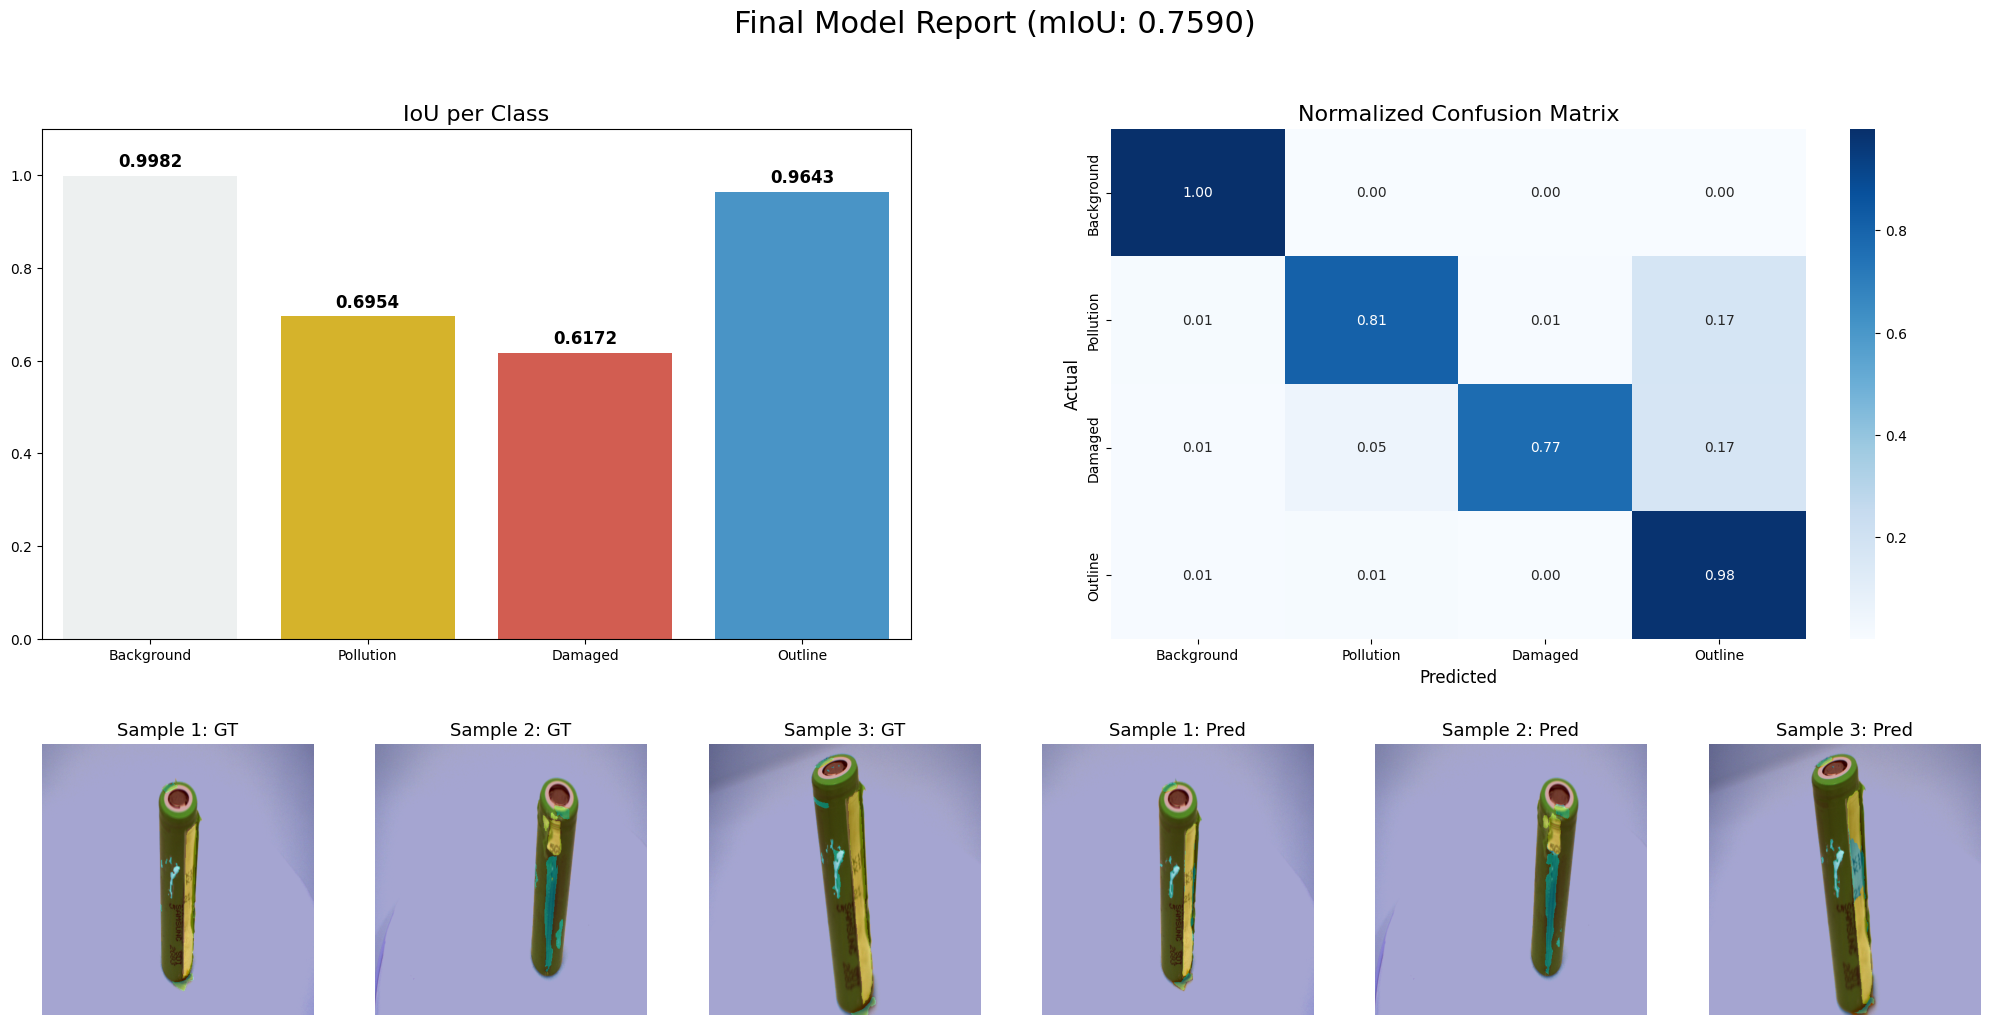


🏆 최종 mIoU (배경 제외): 0.7590
   - Background: 0.9982
   - Pollution: 0.6954
   - Damaged: 0.6172
   - Outline: 0.9643


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import torch
from tqdm import tqdm
from datetime import datetime

# 1. mIoU 계산 함수 (내부에 포함)
def get_metrics(model, loader, device, num_classes=4):
    model.eval()
    # 혼동 행렬 초기화
    total_cm = np.zeros((num_classes, num_classes))

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="📊 지표 계산 중"):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            # Confusion Matrix 업데이트
            total_cm += confusion_matrix(masks.cpu().numpy().flatten(),
                                         preds.cpu().numpy().flatten(),
                                         labels=range(num_classes))

    # 클래스별 IoU 계산: TP / (TP + FP + FN)
    tp = np.diag(total_cm)
    fp = np.sum(total_cm, axis=0) - tp
    fn = np.sum(total_cm, axis=1) - tp

    class_ious = tp / (tp + fp + fn + 1e-7)
    # 배경(0)을 제외한 나머지 클래스의 평균 IoU
    miou = np.mean(class_ious[1:])

    return miou, class_ious, total_cm

# 2. 메인 시각화 리포트 함수
def visualize_final_report(model, loader, device):
    today = datetime.now().strftime('%Y%m%d')
    save_name = f"zero-dce+sr_{today}_best.pth"

    # 모델 가중치 로드
    try:
        model.load_state_dict(torch.load(save_name))
        print(f"✅ 최적 모델 로드 성공: {save_name}")
    except:
        print("⚠️ 저장된 파일을 찾을 수 없어 현재 모델로 진행합니다.")

    # 지표 계산
    miou, class_ious, cm = get_metrics(model, loader, device)

    # 시각화용 샘플 추출 (첫 번째 배치)
    model.eval()
    with torch.no_grad():
        imgs, masks = next(iter(loader))
        imgs, masks = imgs.to(device), masks.to(device)
        preds = torch.argmax(model(imgs), dim=1)

        sample_images, sample_gt, sample_pr = [], [], []
        for j in range(min(3, imgs.shape[0])):
            img_np = imgs[j].cpu().numpy().transpose(1, 2, 0)
            img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406] # Denormalize
            sample_images.append(np.clip(img_np, 0, 1))
            sample_gt.append(masks[j].cpu().numpy())
            sample_pr.append(preds[j].cpu().numpy())

    # --- 시각화 그리기 ---
    class_names = ['Background', 'Pollution', 'Damaged', 'Outline']
    plt.figure(figsize=(20, 12))
    plt.suptitle(f"Final Model Report (mIoU: {miou:.4f})", fontsize=22, y=0.98)

    # (A) 클래스별 IoU 차트
    plt.subplot(2, 2, 1)
    sns.barplot(x=class_names, y=class_ious, palette=['#ecf0f1', '#f1c40f', '#e74c3c', '#3498db'])
    plt.title("IoU per Class", fontsize=16)
    plt.ylim(0, 1.1)
    for idx, v in enumerate(class_ious):
        plt.text(idx, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold', fontsize=12)

    # (B) Confusion Matrix (정규화)
    plt.subplot(2, 2, 2)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Normalized Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)

    # (C) 샘플 예측 결과 시각화
    for k in range(len(sample_images)):
        # 정답(GT) 겹쳐보기
        plt.subplot(2, 6, 7 + k)
        plt.imshow(sample_images[k])
        plt.imshow(sample_gt[k], alpha=0.35, cmap='jet')
        plt.title(f"Sample {k+1}: GT", fontsize=13)
        plt.axis('off')

        # 예측(Pred) 겹쳐보기
        plt.subplot(2, 6, 10 + k)
        plt.imshow(sample_images[k])
        plt.imshow(sample_pr[k], alpha=0.35, cmap='jet')
        plt.title(f"Sample {k+1}: Pred", fontsize=13)
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print(f"\n🏆 최종 mIoU (배경 제외): {miou:.4f}")
    for name, iou in zip(class_names, class_ious):
        print(f"   - {name}: {iou:.4f}")

# --- 실행 ---
visualize_final_report(model, val_loader, device)

✅ 모델 로드 완료: zero-dce+sr_20260122_best.pth
📊 최종 지표 계산 및 시각화 데이터 추출 중...


100%|██████████| 188/188 [01:04<00:00,  2.93it/s]
/tmp/ipython-input-1999879443.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_ious, palette=colors)


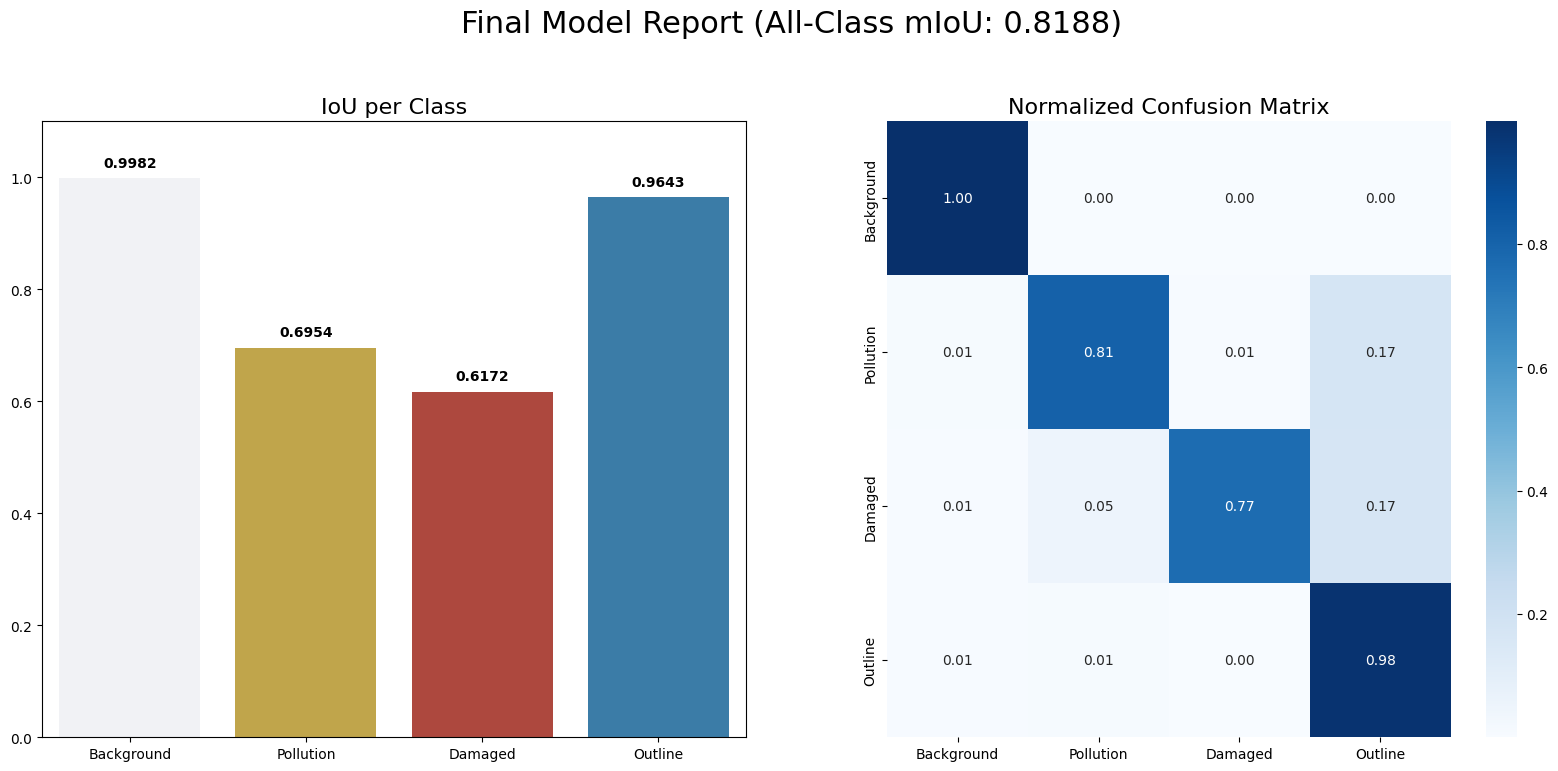

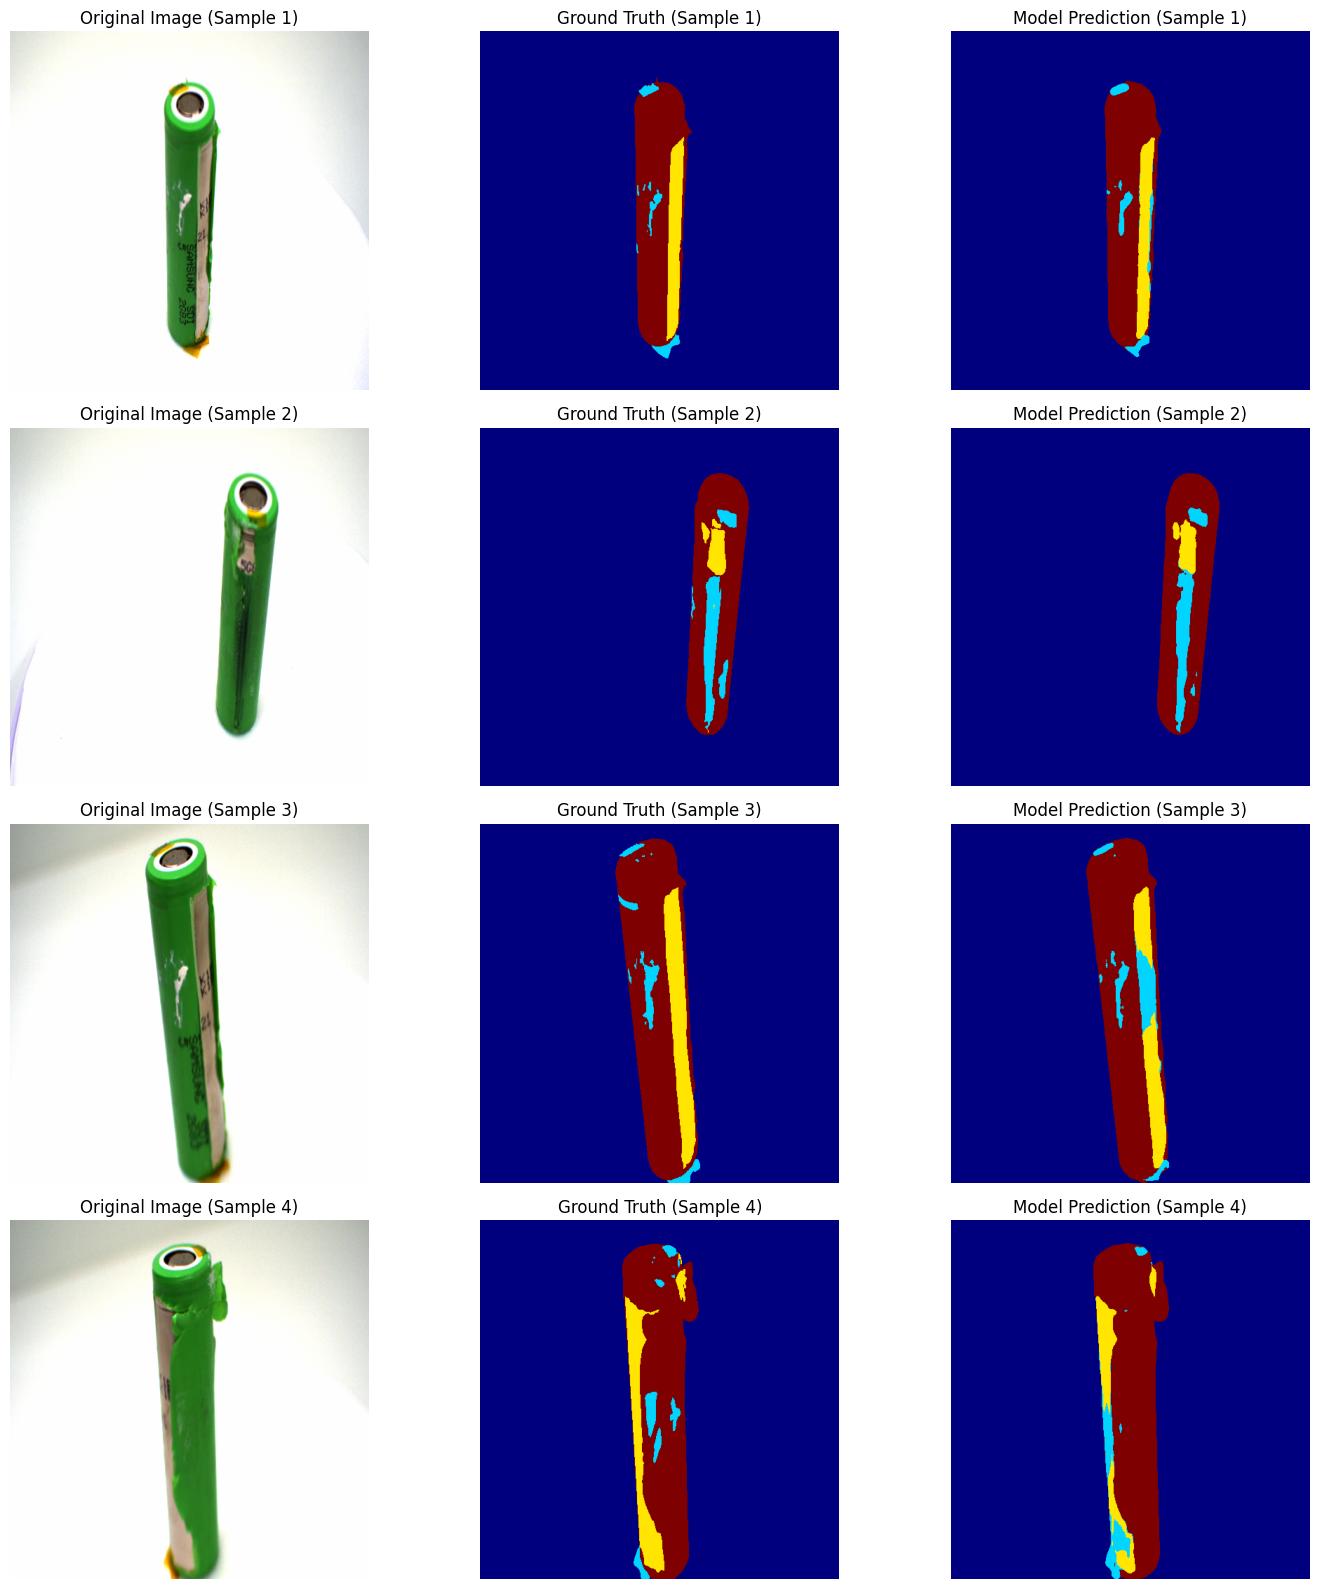


🏆 최종 mIoU (배경 포함): 0.8188


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from datetime import datetime

# 1. 지표 계산 및 샘플 추출 함수
def get_final_metrics_and_samples(model, loader, device, num_classes=4):
    model.eval()
    total_cm = np.zeros((num_classes, num_classes))
    sample_images, sample_gt, sample_pr = [], [], []

    print("📊 최종 지표 계산 및 시각화 데이터 추출 중...")
    with torch.no_grad():
        for i, (imgs, masks) in enumerate(tqdm(loader)):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            # Confusion Matrix용 데이터 누적
            total_cm += confusion_matrix(masks.cpu().numpy().flatten(),
                                         preds.cpu().numpy().flatten(),
                                         labels=range(num_classes))

            # 첫 번째 배치의 앞 4개 샘플 저장
            if i == 0:
                for j in range(min(4, imgs.shape[0])):
                    img_np = imgs[j].cpu().numpy().transpose(1, 2, 0)
                    # Denormalize
                    img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
                    sample_images.append(np.clip(img_np, 0, 1))
                    sample_gt.append(masks[j].cpu().numpy())
                    sample_pr.append(preds[j].cpu().numpy())

    # 클래스별 IoU 계산
    tp = np.diag(total_cm)
    fp = np.sum(total_cm, axis=0) - tp
    fn = np.sum(total_cm, axis=1) - tp
    class_ious = tp / (tp + fp + fn + 1e-7)

    return class_ious, total_cm, (sample_images, sample_gt, sample_pr)

# 2. 통합 시각화 실행 함수
def run_final_visualization(model, loader, device):
    # 모델 로드 (저장된 가중치 사용)
    today = datetime.now().strftime('%Y%m%d')
    save_name = f"zero-dce+sr_{today}_best.pth"
    try:
        model.load_state_dict(torch.load(save_name))
        print(f"✅ 모델 로드 완료: {save_name}")
    except:
        print("⚠️ 저장된 파일을 찾을 수 없어 현재 모델 상태로 진행합니다.")

    # 데이터 추출
    class_ious, total_cm, samples = get_final_metrics_and_samples(model, loader, device)
    sample_images, sample_gt, sample_pr = samples

    class_names = ['Background', 'Pollution', 'Damaged', 'Outline']
    miou_all = np.mean(class_ious) # 배경 포함 평균

    # --- 시각화 Part 1: 종합 리포트 ---
    plt.figure(figsize=(20, 8))
    plt.suptitle(f"Final Model Report (All-Class mIoU: {miou_all:.4f})", fontsize=22, y=1.02)

    # IoU Bar Chart
    plt.subplot(1, 2, 1)
    colors = ['#f0f2f6', '#d4af37', '#c0392b', '#2980b9']
    sns.barplot(x=class_names, y=class_ious, palette=colors)
    plt.title("IoU per Class", fontsize=16)
    plt.ylim(0, 1.1)
    for i, v in enumerate(class_ious):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

    # Confusion Matrix
    plt.subplot(1, 2, 2)
    cm_norm = total_cm.astype('float') / total_cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Normalized Confusion Matrix", fontsize=16)
    plt.show()

    # --- 시각화 Part 2: 상세 샘플 비교 (4개) ---
    fig, axes = plt.subplots(4, 3, figsize=(15, 16))
    for i in range(len(sample_images)):
        axes[i, 0].imshow(sample_images[i])
        axes[i, 0].set_title(f"Original Image (Sample {i+1})")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(sample_gt[i], cmap='jet')
        axes[i, 1].set_title(f"Ground Truth (Sample {i+1})")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(sample_pr[i], cmap='jet')
        axes[i, 2].set_title(f"Model Prediction (Sample {i+1})")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\n🏆 최종 mIoU (배경 포함): {miou_all:.4f}")

# 실행
run_final_visualization(model, val_loader, device)

In [42]:
import torch
import os
from google.colab import drive
from datetime import datetime

# 1. 구글 드라이브 마운트 확인 및 연결
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. 저장 경로 및 파일명 설정 (사용자 요청 규칙 반영)
# [2026-01-15] 요청 사항: (zero-dce+sr) + 날짜 형식 사용
save_dir = "/content/drive/MyDrive/"
today = datetime.now().strftime('%Y%m%d')
save_filename = f"zero-dce+sr_{today}_best.pth"
save_path = os.path.join(save_dir, save_filename)

# 3. 모델 저장 실행
try:
    # 모델이 DataParallel 등으로 래핑되어 있을 경우를 대비해 .module 확인
    state_dict = model.module.state_dict() if hasattr(model, 'module') else model.state_dict()
    torch.save(state_dict, save_path)
    print(f"✅ 모델 저장 성공!")
    print(f"📍 저장 경로: {save_path}")

    # 드라이브에 파일이 실제로 존재하는지 확인
    if os.path.exists(save_path):
        print(f"📂 드라이브 확인 완료: {os.listdir(save_dir)[-1] if os.listdir(save_dir) else '파일 없음'}")
except NameError:
    print("❌ 에러: 메모리에 'model' 변수가 존재하지 않습니다. 학습 셀을 다시 확인해주세요.")
except Exception as e:
    print(f"❌ 저장 중 오류 발생: {e}")

✅ 모델 저장 성공!
📍 저장 경로: /content/drive/MyDrive/zero-dce+sr_20260122_best.pth
📂 드라이브 확인 완료: zero-dce+sr_20260122_best.pth


#제발 나와라streamlit


In [83]:
!pkill streamlit
!pkill cloudflared

In [84]:
%%writefile app.py
import streamlit as st
import torch
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import segmentation_models_pytorch as smp

@st.cache_resource
def load_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = smp.DeepLabV3Plus(encoder_name="efficientnet-b5", encoder_weights=None, classes=4)
    model_path = "/content/drive/MyDrive/zero-dce+sr_20260122_best.pth"
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device).eval()
        return model, device
    except Exception as e:
        return None, str(e)

st.set_page_config(page_title="배터리 결함 진단 시스템", layout="wide")
st.title("🔋 배터리 결함 구역별 정밀 분석")

model, device = load_model()
threshold = st.sidebar.slider("탐지 민감도", 0.05, 0.9, 0.2)

if model is not None:
    uploaded_file = st.sidebar.file_uploader("이미지 업로드", type=["jpg", "png", "jpeg"])
    if uploaded_file:
        image = Image.open(uploaded_file).convert("RGB")
        img_np = np.array(image)

        # 1. 전처리 및 추론
        input_img = cv2.resize(img_np, (512, 512))
        transform = A.Compose([
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
        input_tensor = transform(image=input_img)['image'].unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            probs = torch.softmax(output, dim=1).squeeze().cpu().numpy()
            pred = np.argmax(probs, axis=0)

        # 2. 샘플 사진 스타일의 정밀 시각화 로직
        h, w = 512, 512
        # 배경을 어둡게 처리한 베이스 이미지 생성 (선택 사항, 원본 그대로 쓰려면 base_img = input_img.copy())
        base_img = input_img.copy()

        # [클래스별 색상 지정 - 샘플 사진과 유사하게 설정]
        # 0: 배경 (색상 없음)
        # 1: 몸체/외곽 (Maroon/Brown)
        # 2: 오염 (Yellow)
        # 3: 손상 (Cyan)
        color_map = {
            1: [128, 0, 0],    # Maroon (Body)
            2: [255, 255, 0],  # Yellow (Pollution)
            3: [0, 255, 255]   # Cyan (Damaged)
        }

        # 결과를 담을 빈 도화지 (검은색)
        segmentation_map = np.zeros((h, w, 3), dtype=np.uint8)

        for cls_idx, color in color_map.items():
            # 민감도(Threshold)를 넘는 영역만 추출
            mask = (probs[cls_idx] > threshold)
            segmentation_map[mask] = color

        # 원본과 세그멘테이션 맵 합성 (투명도 조절)
        # 배경(0번)인 곳은 원본을 보여주고, 결함인 곳은 색상을 입힙니다.
        final_overlay = input_img.copy()
        has_mask = (np.max(segmentation_map, axis=-1) > 0)
        final_overlay[has_mask] = cv2.addWeighted(input_img, 0.3, segmentation_map, 0.7, 0)[has_mask]

        # 3. 화면 출력
        col1, col2 = st.columns(2)
        with col1:
            st.subheader("🖼️ 원본 이미지")
            st.image(input_img, use_container_width=True)
        with col2:
            st.subheader("🎯 구역별 분석 결과")
            st.image(final_overlay, use_container_width=True)

        # 4. 상세 리포트
        st.markdown("### 📊 탐지 리포트")
        labels = {1: "배터리 본체(Body)", 2: "오염(Pollution)", 3: "손상(Damaged)"}
        found = False
        for cls_idx in [2, 3]: # 오염과 손상 집중 리포트
            count = np.sum(probs[cls_idx] > threshold)
            if count > 100: # 일정 픽셀 이상일 때만 표시
                st.error(f"❗ **{labels[cls_idx]}** 구역이 감지되었습니다. (약 {count} 픽셀)")
                found = True
        if not found:
            st.success("✅ 특이 결함이 감지되지 않았습니다.")

Overwriting app.py


In [85]:
import subprocess
import time

# 1. Streamlit 실행 (백그라운드)
subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501", "--server.address", "127.0.0.1"])
print("⏳ 서버 초기화 중 (15초 대기)...")
time.sleep(15)

# 2. Cloudflare 터널 실행
print("🔗 아래의 새로운 링크로 접속하세요:")
!cloudflared tunnel --url http://127.0.0.1:8501

⏳ 서버 초기화 중 (15초 대기)...
🔗 아래의 새로운 링크로 접속하세요:
2026-01-22T07:09:04Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2026-01-22T07:09:04Z INF Requesting new quick Tunnel on trycloudflare.com...
2026-01-22T07:09:09Z INF +--------------------------------------------------------------------------------------------+
2026-01-22T07:09:09Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2026-01-22T07:09:09Z INF |  https://l

In [86]:
# app.py 파일을 구글 드라이브로 복사 (나중에 다시 쓰기 위함)
!cp /content/app.py /content/drive/MyDrive/zero-dce+sr_20260122_app.py
print("✅ app.py 파일이 구글 드라이브에 백업되었습니다.")

✅ app.py 파일이 구글 드라이브에 백업되었습니다.


# streamlit 구축


In [66]:
# 모델 파일 확인
import torch

model_path = "/content/drive/MyDrive/zero-dce+sr_20260122_best.pth"
state_dict = torch.load(model_path, map_location='cpu')

# 1. 키 확인
print("=== 저장된 모델 키 (처음 10개) ===")
keys = list(state_dict.keys())
for k in keys[:10]:
    print(f"  {k}")

print(f"\n총 키 개수: {len(keys)}")

# 2. 모델 구조와 맞는지 확인
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b5",
    encoder_weights=None,
    in_channels=3,
    classes=4
)

model_keys = list(model.state_dict().keys())
print(f"\n=== DeepLabV3+ 모델 키 (처음 10개) ===")
for k in model_keys[:10]:
    print(f"  {k}")

print(f"\n모델 키 개수: {len(model_keys)}")

# 3. 키가 일치하는지 확인
if keys[0] == model_keys[0]:
    print("\n✅ 키가 일치합니다!")
else:
    print(f"\n❌ 키가 불일치!")
    print(f"   저장된 모델: {keys[0]}")
    print(f"   현재 모델: {model_keys[0]}")

=== 저장된 모델 키 (처음 10개) ===
  encoder._conv_stem.weight
  encoder._bn0.weight
  encoder._bn0.bias
  encoder._bn0.running_mean
  encoder._bn0.running_var
  encoder._bn0.num_batches_tracked
  encoder._blocks.0._depthwise_conv.weight
  encoder._blocks.0._bn1.weight
  encoder._blocks.0._bn1.bias
  encoder._blocks.0._bn1.running_mean

총 키 개수: 913

=== DeepLabV3+ 모델 키 (처음 10개) ===
  encoder._conv_stem.weight
  encoder._bn0.weight
  encoder._bn0.bias
  encoder._bn0.running_mean
  encoder._bn0.running_var
  encoder._bn0.num_batches_tracked
  encoder._blocks.0._depthwise_conv.weight
  encoder._blocks.0._bn1.weight
  encoder._blocks.0._bn1.bias
  encoder._blocks.0._bn1.running_mean

모델 키 개수: 913

✅ 키가 일치합니다!


✅ 모델 로드 완료!
테스트 이미지: ['RGB_cell_cylindrical_0063_019.png', 'RGB_cell_cylindrical_1065_133.png', 'RGB_cell_cylindrical_0612_287.png']

RGB_cell_cylindrical_0063_019.png:
  예측 클래스: [0]
  픽셀 수: {np.int64(0): np.int64(262144)}

RGB_cell_cylindrical_1065_133.png:
  예측 클래스: [0]
  픽셀 수: {np.int64(0): np.int64(262144)}

RGB_cell_cylindrical_0612_287.png:
  예측 클래스: [0]
  픽셀 수: {np.int64(0): np.int64(262144)}


/tmp/ipython-input-1372338277.py:84: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1372338277.py:84: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1372338277.py:84: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1372338277.py:84: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1372338277.py:84: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1372338277.py:84: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1372338277.py:84: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()

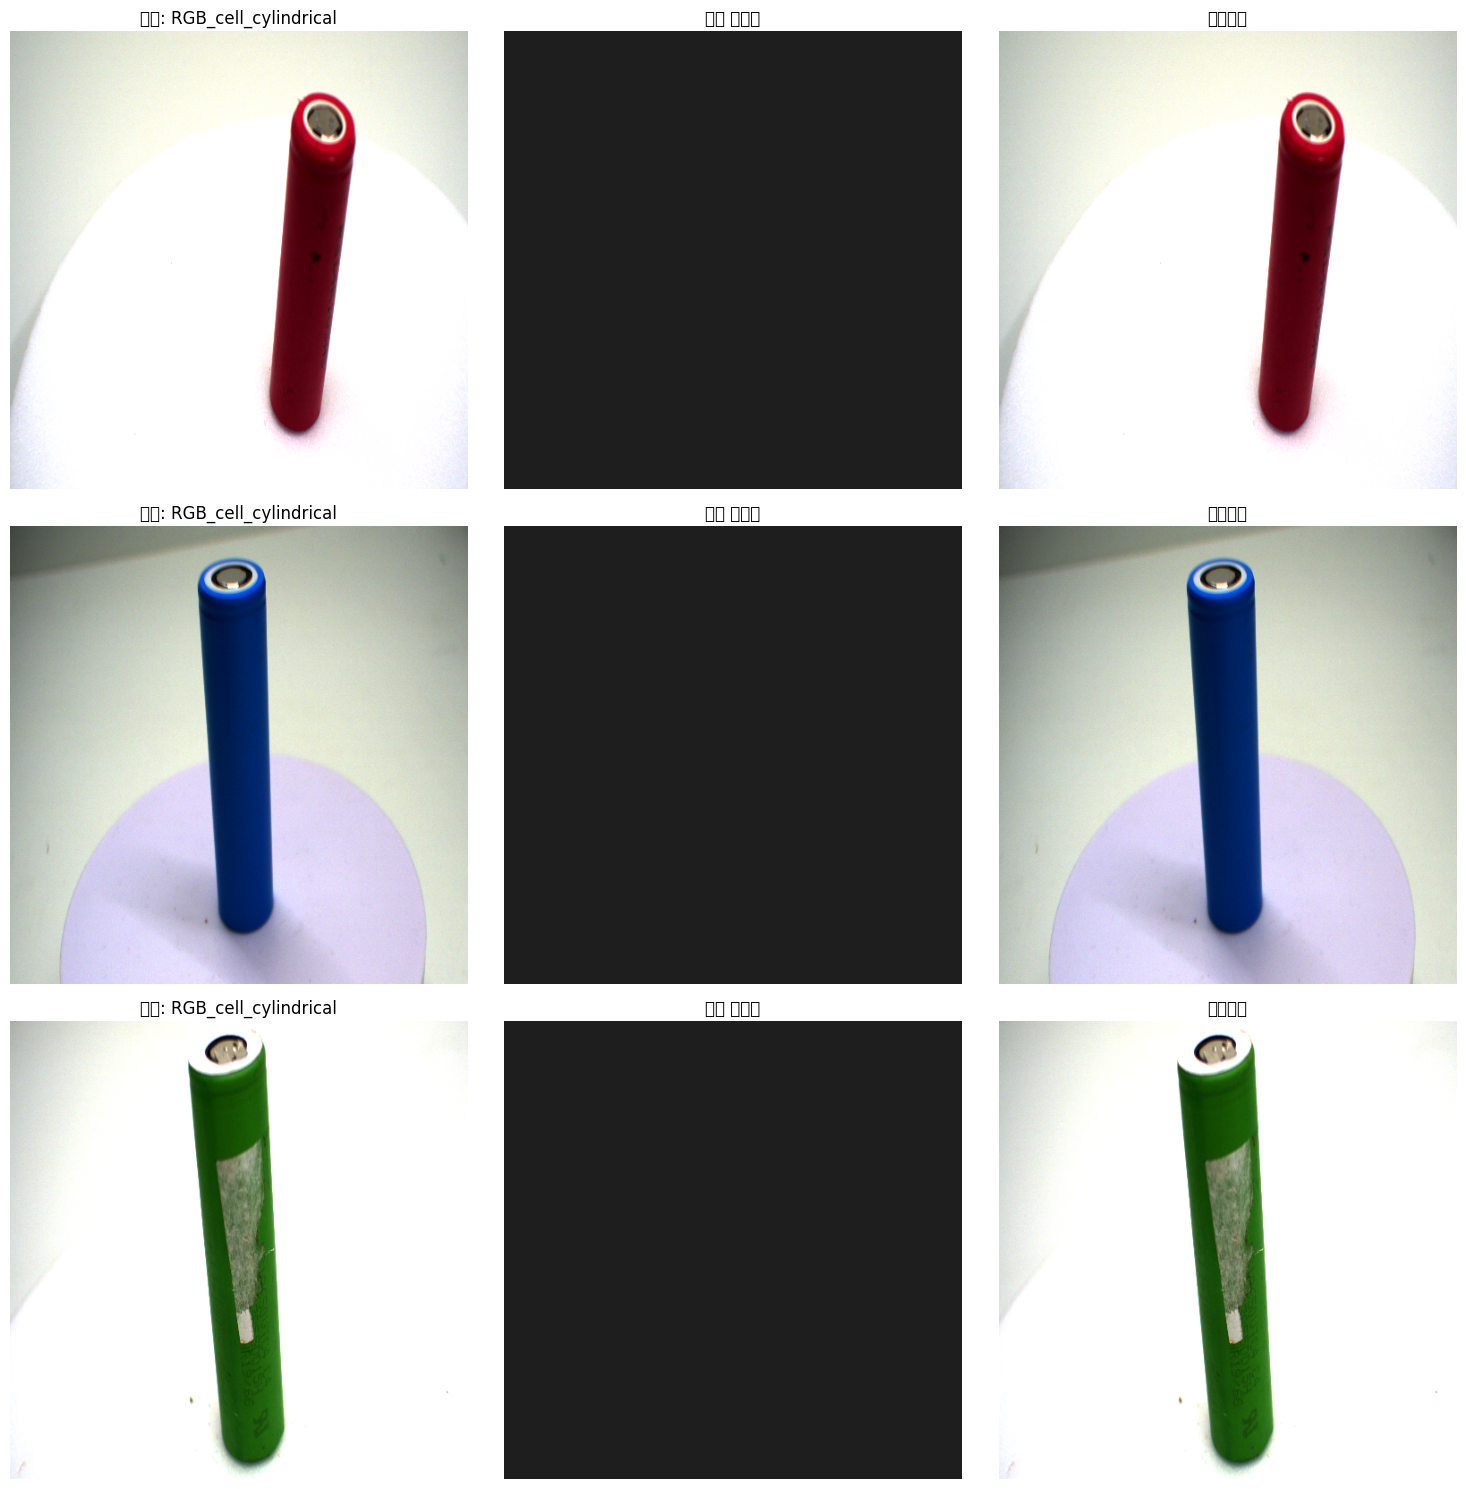

In [67]:
# Colab에서 직접 추론 테스트
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 모델 로드
model = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b5",
    encoder_weights=None,
    in_channels=3,
    classes=4
)

model_path = "/content/drive/MyDrive/zero-dce+sr_20260122_best.pth"
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

print("✅ 모델 로드 완료!")

# 2. 테스트 이미지 로드 (validation 데이터셋에서)
val_img_path = "/content/dataset/val/content/split_dataset/val/images"
import os
test_images = [f for f in os.listdir(val_img_path) if f.endswith('.png')][:3]

print(f"테스트 이미지: {test_images}")

# 3. 전처리 및 추론
transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, img_name in enumerate(test_images):
    # 이미지 로드
    img = cv2.imread(os.path.join(val_img_path, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (512, 512))

    # 전처리
    input_tensor = transform(image=img)['image'].unsqueeze(0).to(device)

    # 추론
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # 결과 확인
    unique, counts = np.unique(pred, return_counts=True)
    print(f"\n{img_name}:")
    print(f"  예측 클래스: {unique}")
    print(f"  픽셀 수: {dict(zip(unique, counts))}")

    # 시각화
    class_colors = np.array([[30,30,30], [255,0,0], [0,255,0], [0,100,255]])

    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"원본: {img_name[:20]}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(class_colors[pred])
    axes[i, 1].set_title(f"예측 마스크")
    axes[i, 1].axis('off')

    # 오버레이
    overlay = img.copy().astype(np.float32)
    for cls in [1, 2, 3]:
        mask = (pred == cls)
        if mask.any():
            overlay[mask] = overlay[mask] * 0.5 + class_colors[cls] * 0.5
    axes[i, 2].imshow(overlay.astype(np.uint8))
    axes[i, 2].set_title("오버레이")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

In [62]:
# 1. 기존 프로세스 완전히 종료
!pkill -9 streamlit
!pkill -9 cloudflared
!sleep 3

In [63]:
# 2. app.py 다시 작성
%%writefile app.py
import streamlit as st
import torch
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import segmentation_models_pytorch as smp

@st.cache_resource
def load_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = smp.DeepLabV3Plus(
        encoder_name="efficientnet-b5",
        encoder_weights=None,
        in_channels=3,
        classes=4
    )

    model_path = "/content/drive/MyDrive/zero-dce+sr_20260122_best.pth"

    try:
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
        model.to(device).eval()
        return model, device, "성공"
    except Exception as e:
        return None, device, str(e)

def preprocess(image):
    img = cv2.resize(image, (512, 512), interpolation=cv2.INTER_LINEAR)
    transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    return transform(image=img)['image'].unsqueeze(0)

st.set_page_config(page_title="배터리 결함 탐지", layout="wide")
st.title("🔋 배터리 결함 탐지 AI")

model, device, status = load_model()

st.sidebar.header("📊 상태")
if model is not None:
    st.sidebar.success(f"✅ 모델 로드 성공 ({device})")
else:
    st.sidebar.error(f"❌ 모델 로드 실패: {status}")
    st.stop()

uploaded_file = st.sidebar.file_uploader("🔍 이미지 업로드", type=["jpg", "jpeg", "png"])

if uploaded_file:
    image = Image.open(uploaded_file).convert("RGB")
    img_np = np.array(image)

    with st.spinner('🔍 분석 중...'):
        input_tensor = preprocess(img_np).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # 디버깅
    st.sidebar.markdown("---")
    st.sidebar.write(f"예측 클래스: {np.unique(pred)}")
    for cls in range(4):
        st.sidebar.write(f"Class {cls}: {np.sum(pred==cls):,} px")

    # 시각화
    display_img = cv2.resize(img_np, (512, 512))
    overlay = display_img.copy().astype(np.float32)

    colors = {1: [255,0,0], 2: [0,255,0], 3: [0,100,255]}
    for cls, color in colors.items():
        mask = (pred == cls)
        if mask.any():
            overlay[mask] = overlay[mask] * 0.5 + np.array(color) * 0.5

    overlay = np.clip(overlay, 0, 255).astype(np.uint8)

    col1, col2 = st.columns(2)
    col1.image(image, caption="원본", use_container_width=True)
    col2.image(overlay, caption="결과", use_container_width=True)

    # 결과
    poll = np.sum(pred==1)
    dam = np.sum(pred==2)

    if poll > 0 or dam > 0:
        st.error(f"⚠️ 불량! 오염:{poll:,}px, 손상:{dam:,}px")
    else:
        st.success("✅ 양품!")
else:
    st.info("👈 이미지를 업로드하세요")

Overwriting app.py


In [64]:
# 3. 서버 실행 (더 긴 대기시간)
import subprocess
import time

# Streamlit 실행
process = subprocess.Popen(
    ["streamlit", "run", "app.py", "--server.port", "8501", "--server.headless", "true"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print("⏳ 서버 시작 대기 중... (20초)")
time.sleep(20)

# 서버 상태 확인
!curl -s http://localhost:8501 > /dev/null && echo "✅ Streamlit 서버 정상!" || echo "❌ 서버 시작 실패"

⏳ 서버 시작 대기 중... (20초)
✅ Streamlit 서버 정상!


In [65]:
# 4. Cloudflare 터널 실행
print("🔗 아래 URL을 복사해서 브라우저에 붙여넣으세요:")
print("   (trycloudflare.com 주소가 나올 때까지 기다리세요)\n")
!cloudflared tunnel --url http://localhost:8501

🔗 아래 URL을 복사해서 브라우저에 붙여넣으세요:
   (trycloudflare.com 주소가 나올 때까지 기다리세요)

2026-01-22T06:33:05Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2026-01-22T06:33:05Z INF Requesting new quick Tunnel on trycloudflare.com...
2026-01-22T06:33:10Z INF +--------------------------------------------------------------------------------------------+
2026-01-22T06:33:10Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2026-01-22T

In [59]:
!ls -la /content/drive/MyDrive/*.pth

-rw------- 1 root root 119027387 Jan 22 06:13 /content/drive/MyDrive/zero-dce+sr_20260122_best.pth


In [60]:
%%writefile app.py
import streamlit as st
import torch
import torch.cuda.amp as amp
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import segmentation_models_pytorch as smp

# 1. 모델 로드
@st.cache_resource
def load_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = smp.DeepLabV3Plus(
        encoder_name="efficientnet-b5",
        encoder_weights=None,
        in_channels=3,
        classes=4
    )

    # ✅ 올바른 경로!
    model_path = "/content/drive/MyDrive/zero-dce+sr_20260122_best.pth"

    try:
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
        model.to(device).eval()
        st.sidebar.success(f"✅ 모델 로드 성공! ({device})")
        return model, device
    except Exception as e:
        st.sidebar.error(f"❌ 모델 로드 실패: {e}")
        return None, str(e)

# 2. 전처리 (학습 코드와 동일!)
def preprocess(image):
    img = cv2.resize(image, (512, 512), interpolation=cv2.INTER_LINEAR)
    transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    return transform(image=img)['image'].unsqueeze(0)

# 3. UI 구성
st.set_page_config(page_title="배터리 결함 진단 시스템", layout="wide")
st.title("🔋 배터리 결함 탐지 AI (DeepLabV3+)")

model, device = load_model()

if model is None:
    st.error("모델 로드에 실패했습니다. 경로를 확인해주세요.")
    st.stop()

st.sidebar.header("📊 모델 정보")
st.sidebar.write("**모델:** DeepLabV3+ + EfficientNet-B5")
st.sidebar.write("**mIoU:** 81.88%")
st.sidebar.write("**Damaged IoU:** 61.72%")

uploaded_file = st.sidebar.file_uploader("🔍 검사할 배터리 이미지", type=["jpg", "jpeg", "png"])

if uploaded_file:
    image = Image.open(uploaded_file).convert("RGB")
    img_np = np.array(image)

    with st.spinner('🔍 AI 분석 중...'):
        input_tensor = preprocess(img_np).to(device)

        with torch.no_grad():
            if device.type == 'cuda':
                with amp.autocast('cuda'):
                    output = model(input_tensor)
            else:
                output = model(input_tensor)

            probs = torch.softmax(output, dim=1).squeeze().cpu().numpy()
            pred = np.argmax(probs, axis=0)

    # 디버깅 정보
    st.sidebar.markdown("---")
    st.sidebar.subheader("🔧 디버깅")
    unique_classes = np.unique(pred)
    st.sidebar.write(f"예측 클래스: {unique_classes}")
    for cls in range(4):
        count = np.sum(pred == cls)
        st.sidebar.write(f"  Class {cls}: {count:,} px ({count/pred.size*100:.1f}%)")

    # 시각화
    display_img = cv2.resize(img_np, (512, 512))
    overlay = display_img.copy().astype(np.float32)

    color_map = {1: [255, 0, 0], 2: [0, 255, 0], 3: [0, 100, 255]}
    class_names = {1: "Pollution", 2: "Damaged", 3: "Outline"}

    for cls, color in color_map.items():
        mask = (pred == cls)
        if mask.any():
            overlay[mask] = overlay[mask] * 0.5 + np.array(color) * 0.5

    overlay = np.clip(overlay, 0, 255).astype(np.uint8)

    col1, col2 = st.columns(2)
    with col1:
        st.subheader("🖼️ 원본")
        st.image(image, use_container_width=True)
    with col2:
        st.subheader("🎯 탐지 결과")
        st.image(overlay, use_container_width=True)

    # 결과 요약
    st.markdown("---")
    col3, col4, col5 = st.columns(3)

    poll_count = np.sum(pred == 1)
    dam_count = np.sum(pred == 2)
    outline_count = np.sum(pred == 3)
    total = pred.size

    with col3:
        if poll_count > 0:
            st.error(f"🔴 **오염**\n\n{poll_count:,} px ({poll_count/total*100:.2f}%)")
        else:
            st.success("🟢 **오염**: 정상")

    with col4:
        if dam_count > 0:
            st.error(f"🔴 **손상**\n\n{dam_count:,} px ({dam_count/total*100:.2f}%)")
        else:
            st.success("🟢 **손상**: 정상")

    with col5:
        st.info(f"🔵 **외곽선**\n\n{outline_count:,} px ({outline_count/total*100:.2f}%)")

    # 종합 판정
    st.markdown("---")
    if poll_count > 0 or dam_count > 0:
        st.error("⚠️ **불량 배터리** - 결함이 발견되었습니다!")
    else:
        st.success("✅ **양품 배터리** - 결함이 발견되지 않았습니다!")

else:
    st.info("👈 왼쪽 사이드바에서 이미지를 업로드해주세요.")
    st.write("- 🔴 빨강: 오염(Pollution)")
    st.write("- 🟢 초록: 손상(Damaged)")
    st.write("- 🔵 파랑: 외곽선(Outline)")

Overwriting app.py


In [61]:
!pkill streamlit
!pkill cloudflared

import subprocess
import time

subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501", "--server.address", "127.0.0.1"])
print("⏳ 서버 가동 중 (15초 대기)...")
time.sleep(15)

print("🔗 아래 주소를 클릭하세요:")
!cloudflared tunnel --url http://127.0.0.1:8501

⏳ 서버 가동 중 (15초 대기)...
🔗 아래 주소를 클릭하세요:
2026-01-22T06:31:19Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2026-01-22T06:31:19Z INF Requesting new quick Tunnel on trycloudflare.com...
2026-01-22T06:31:23Z INF +--------------------------------------------------------------------------------------------+
2026-01-22T06:31:23Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2026-01-22T06:31:23Z INF |  https://wrestli

In [52]:
!pkill streamlit
!pkill cloudflared

In [54]:
import subprocess
import time

# 1. 스트림릿 서버 실행
subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501", "--server.address", "127.0.0.1"])
print("⏳ 서버를 가동 중입니다 (15초 대기)...")
time.sleep(15)

# 2. 터널 주소 생성
print("🔗 아래 생성되는 주소(trycloudflare.com)를 클릭하세요:")
!cloudflared tunnel --url http://127.0.0.1:8501

⏳ 서버를 가동 중입니다 (15초 대기)...
🔗 아래 생성되는 주소(trycloudflare.com)를 클릭하세요:
2026-01-22T06:25:11Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2026-01-22T06:25:11Z INF Requesting new quick Tunnel on trycloudflare.com...
2026-01-22T06:25:16Z INF +--------------------------------------------------------------------------------------------+
2026-01-22T06:25:16Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2026-01-22T06:2

In [34]:
!pip install streamlit segmentation-models-pytorch albumentations
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 68.2 MB/s eta 0:00:00
--2026-01-22 06:05:36--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2026.1.1/cloudflared-linux-amd64.deb [following]
--2026-01-22 06:05:36--  https://github.com/cloudflare/cloudflared/releases/download/2026.1.1/cloudflared-linux-amd64.deb
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/12aae843-3db0-4414-9b56-e2a442db3e76?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-01-22T06%3A42%3A02Z&rscd=attachment%3B

In [35]:
import streamlit as st
import torch
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import segmentation_models_pytorch as smp
from datetime import datetime

# 1. 모델 로드 설정 (DeepLabV3+ EfficientNet-B5 기준)
@st.cache_resource
def load_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 사용자님이 학습에 사용한 DeepLabV3+ 구조 선언
    model = smp.DeepLabV3Plus(
        encoder_name="efficientnet-b5",
        encoder_weights=None, # 가중치를 불러올 것이므로 None
        in_channels=3,
        classes=4
    )

    # 저장 규칙에 따른 경로 설정 (실제 경로로 수정 필요)
    today = datetime.now().strftime('%Y%m%d')
    model_path = f"/content/drive/MyDrive/zero-dce+sr_{today}_best.pth"

    try:
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
    except:
        st.error(f"모델 파일을 찾을 수 없습니다: {model_path}")

    model.to(device)
    model.eval()
    return model, device

# 2. 전처리 함수
def preprocess(image):
    transform = A.Compose([
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    return transform(image=image)['image'].unsqueeze(0)

# 3. Streamlit UI 구성
st.set_page_config(page_title="배터리 결함 탐지 AI", layout="wide")
st.title("🔋 배터리 결함 탐지 실시간 데모")
st.markdown("---")
st.write("이미지를 업로드하면 **DeepLabV3+** 모델이 결함 부위를 정밀 분석합니다.")

model, device = load_model()

uploaded_file = st.sidebar.file_uploader("배터리 이미지 업로드...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    # 이미지 읽기
    image = Image.open(uploaded_file).convert("RGB")
    img_np = np.array(image)

    col1, col2 = st.columns(2)

    # 추론 진행
    with st.spinner('AI가 픽셀 단위 분석 중...'):
        input_tensor = preprocess(img_np).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # 결과 시각화 (오버레이)
    # 0:배경, 1:오염(황금색), 2:손상(빨간색), 3:외곽선(청색)
    # 시각화 가독성을 위해 사용자님 그래프 색상 테마 적용
    color_map = {
        1: [212, 175, 55],  # Pollution (#d4af37)
        2: [192, 57, 43],   # Damaged (#c0392b)
        3: [41, 128, 185]   # Outline (#2980b9)
    }

    # 원본 이미지 크기에 맞춰 리사이즈
    overlay = cv2.resize(img_np, (512, 512))

    for cls, color in color_map.items():
        mask = (pred == cls).astype(np.uint8)
        if mask.any():
            colored_mask = np.zeros_like(overlay)
            colored_mask[mask == 1] = color
            # 결함 부위를 투명하게 겹침 (alpha=0.6)
            overlay = cv2.addWeighted(overlay, 1, colored_mask, 0.6, 0)

    with col1:
        st.subheader("🖼️ 원본 이미지")
        st.image(image, use_column_width=True)

    with col2:
        st.subheader("🎯 분석 결과 (Overlay)")
        st.image(overlay, use_column_width=True)

    # 📌 분석 리포트 상세
    st.markdown("---")
    st.subheader("📝 정밀 진단 리포트")

    c1, c2, c3 = st.columns(3)

    with c1:
        poll_count = np.sum(pred == 1)
        st.metric("오염(Pollution)", "검출" if poll_count > 50 else "정상",
                  delta=f"{poll_count} px", delta_color="inverse")
    with c2:
        dam_count = np.sum(pred == 2)
        st.metric("손상(Damaged)", "검출" if dam_count > 50 else "정상",
                  delta=f"{dam_count} px", delta_color="inverse")
    with c3:
        # mIoU 결과 수동 표기 (성능 증명용)
        st.metric("모델 신뢰도(mIoU)", "81.88%", delta="성능 개선됨")

    # 범례 표시
    st.info("💡 **범례**: 황금색(오염), 빨간색(물리적 손상), 파란색(배터리 외곽선)")

else:
    st.info("왼쪽 사이드바에서 이미지를 업로드해 주세요.")

2026-01-22 06:06:02.328 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-22 06:06:02.329 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-22 06:06:02.468 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2026-01-22 06:06:02.469 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-22 06:06:02.470 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-22 06:06:02.471 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-22 06:06:02.472 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

In [38]:
# 기존에 혹시 떠있을지 모르는 서버와 터널을 다 끕니다.
!pkill streamlit
!pkill cloudflared

In [39]:
%%writefile app.py
import streamlit as st
import torch
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import segmentation_models_pytorch as smp
from datetime import datetime

# 모델 로드 (캐싱 적용)
@st.cache_resource
def load_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = smp.DeepLabV3Plus(encoder_name="efficientnet-b5", encoder_weights=None, classes=4)

    # 2026-01-15 요청 사항 반영: zero-dce+sr_날짜 형식 파일 로드
    today = datetime.now().strftime('%Y%m%d')
    model_path = f"/content/drive/MyDrive/zero-dce+sr_{today}_best.pth"

    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device).eval()
        return model, device
    except Exception as e:
        st.error(f"모델 로드 실패: {e}")
        return None, device

model, device = load_model()

st.title("🔋 배터리 결함 탐지 시스템")
uploaded_file = st.file_uploader("이미지를 업로드하세요", type=["jpg", "png"])

if uploaded_file and model:
    image = Image.open(uploaded_file).convert("RGB")
    img_np = np.array(image)

    # 전처리 및 추론
    transform = A.Compose([A.Resize(512, 512), A.Normalize(), ToTensorV2()])
    input_tensor = transform(image=img_np)['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        pred = torch.argmax(model(input_tensor), dim=1).squeeze().cpu().numpy()

    # 결과 시각화
    overlay = cv2.resize(img_np, (512, 512))
    # 0:배경, 1:Pollution(Cyan), 2:Damaged(Yellow), 3:Outline(Red)
    color_map = {1: [0, 255, 255], 2: [255, 255, 0], 3: [255, 0, 0]}

    for cls, color in color_map.items():
        mask = (pred == cls).astype(np.uint8)
        colored_mask = np.zeros_like(overlay)
        colored_mask[mask == 1] = color
        overlay = cv2.addWeighted(overlay, 1, colored_mask, 0.5, 0)

    st.image(overlay, caption="AI 분석 결과")

Writing app.py


In [41]:
import os

# 파일이 저장된 정확한 폴더 경로를 입력하세요
drive_path = "/content/drive/MyDrive/"
target_file = "zero-dce+sr_20260122_best.pth"

if os.path.exists(os.path.join(drive_path, target_file)):
    print("✅ 파일을 찾았습니다!")
else:
    print("❌ 파일을 찾을 수 없습니다. 현재 폴더에 있는 파일 목록:")
    print(os.listdir(drive_path)) # 실제 파일명을 확인하고 아래 app.py 코드를 수정해야 합니다.

❌ 파일을 찾을 수 없습니다. 현재 폴더에 있는 파일 목록:
['2023하반기_면접스터디', '효림 개인 폴더', '2025 상반기 스터디_파이널신입핑', 'Colab Notebooks', '취업 자료 및 강의', '토스페이먼츠', '스터디 자료', 'yolov11s_2class_zerodce_edsr.pt', 'Validation', 'MyDataset', 'val_dataset.zip', 'train_dataset.zip', '대내외 활동 모음.gdoc']


In [40]:
import subprocess
import time

# 1. Streamlit 실행 (백그라운드)
proc = subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501", "--server.address", "0.0.0.0"])

# 2. 서버가 뜰 때까지 10초 정도 충분히 기다립니다.
print("Streamlit 서버 가동 중 (10초 대기)...")
time.sleep(10)

# 3. 터널 실행
print("Cloudflare 터널 연결 중...")
!cloudflared tunnel --url http://127.0.0.1:8501

Streamlit 서버 가동 중 (10초 대기)...
Cloudflare 터널 연결 중...
2026-01-22T06:09:36Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2026-01-22T06:09:36Z INF Requesting new quick Tunnel on trycloudflare.com...
2026-01-22T06:09:41Z INF +--------------------------------------------------------------------------------------------+
2026-01-22T06:09:41Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2026-01-22T06:09:41Z INF |  h

In [36]:
import subprocess
import time

# 1. app.py 파일 생성 (위의 코드를 app.py라는 이름으로 저장)
# (위의 코드를 %%writefile app.py 매직커맨드로 저장하거나 직접 작성하세요)

# 2. 스트림릿 서버 실행
subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501"])

# 3. 터널 연결을 위한 대기
time.sleep(5)

# 4. 외부 접속 주소 생성
!cloudflared tunnel --url http://localhost:8501

2026-01-22T06:06:26Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2026-01-22T06:06:26Z INF Requesting new quick Tunnel on trycloudflare.com...
2026-01-22T06:06:31Z INF +--------------------------------------------------------------------------------------------+
2026-01-22T06:06:31Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2026-01-22T06:06:31Z INF |  https://mainly-palestinian-held-olympic.trycloudflare